# Task 2 Physio-Itera Correlation Study

### Result
- It seems the correlation between using time doamin hrv give perfectly linear correlation between the short GT vs full GT and short rppg with full rppg.

- The short term rPPG vs full length GT PPG shows linearly positive moderate result on certain features, especially on the HR related one. as many paper stated, HR increase tends to make the humans also stress, but the **study on the limit of aggrement and the mean bias should be done and the use case of correction model** should be put into consideration

- Correlation using Baevsky Stress Index give moderate / poor result, probably since it not based on the data, rather it based on statistical data (modus, standard deviation) and the formula, itself.

- If this was accepted, For Real-Time Use: Consider BSI with Caution

- Also learn with the correction model from the bland-altman analysis

### Important Note
This notebook performs correlation analysis between ground truth physiological signals and remote photoplethysmography (rPPG) signals from the UBFC-Phys dataset. It implements proper signal processing to convert BVP/PPG signals to RR intervals and calculates various HRV metrics including the Baevsky Stress Index.

In [1]:
# UST HRV and Normal HRV Correlation Analysis for Stress Detection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

## Import the utils helper
from utils.compute_bsi import compute_bsi
from utils.compute_hrv_features import compute_hrv_features
from utils.compute_rr_interval import convert_bvp_to_rr
from utils.plot_bland_altman import bland_altman_plot, create_individual_bland_altman_plots, create_combined_bland_altman_plot, create_feature_bland_altman_plots, plot_method_comparisons
from utils.remove_outlier import remove_outliers
from utils.segment_data import segment_data
from utils.plot_correlation import compute_correlations, plot_correlation_comparison, compute_feature_correlations, plot_all_feature_correlations, summarize_feature_correlations, compute_method_correlations

### Main methods

This methods consist of several things, to simplify the pipeline, it will be on several steps

For this purpose, this notebook will only be on the Tasks based on the file name

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

print("Starting HRV correlation analysis for stress detection...")

# Step 1: Load Data from Physio-Itera dataset
print("Loading data from Physio-Itera dataset...")

base_path=f"PhysioItera"
subjects=os.listdir(base_path)

# Store ground truth and rPPG data
gt_data = {}
rppg_data = {
    'POS': {},
    'LGI': {},
    'OMIT': {},
    'GREEN': {},
    'CHROM': {}
}
# Expected sampling rates (adjust if different for your dataset)
sample_rate_gt = 200  # Hz
sample_rate_video = 30 # Hz

# Counter for subject processing
processed_subjects = 0
visualize = True  # Set to True to visualize the peak detection process

# Process each subject and task
for subject in subjects:
    # Check if subject folder exists
    ## Make sure the folder ends in "2" for this subject
    if not subject.endswith("6"):
        # print(f"Subject {subject} not found, skipping")
        continue

    working_folder = base_path + f"/{subject}"
    
    # Generate a unique ID for each subject-task combination
    subject_task_id = f"{subject}"
    
    try:
        # Load rPPG signals from different methods
        pos = np.load(os.path.join(working_folder, f"Landmark-{subject}-POS-rppg.npy"))
        lgi = np.load(os.path.join(working_folder, f"Landmark-{subject}-LGI-rppg.npy"))
        omit = np.load(os.path.join(working_folder, f"Landmark-{subject}-OMIT-rppg.npy"))
        green = np.load(os.path.join(working_folder, f"Landmark-{subject}-GREEN-rppg.npy"))
        chrom = np.load(os.path.join(working_folder, f"Landmark-{subject}-CHROM-rppg.npy"))

        # Load ground truth BVP
        gt_path = os.path.join(working_folder, f"vernier/{subject}_vernier_ecg.csv")
        GT = pd.read_csv(gt_path, usecols=[1], header=None).values
        GT = GT.flatten()
        
        # Extract RR intervals from ground truth and rPPG signals
        gt_rr = convert_bvp_to_rr(GT, sampling_rate=sample_rate_gt, visualize=visualize, task="T1", subject="GT")
        
        # Use POS method as the primary rPPG signal
        # You could also implement a fusion approach or compare different methods
        pos_rr = convert_bvp_to_rr(pos, sampling_rate=sample_rate_video, visualize=visualize, task="T1", subject=f"{subject}_POS")
        lgi_rr = convert_bvp_to_rr(lgi, sampling_rate=sample_rate_video, visualize=visualize, task="T1", subject=f"{subject}_LGI")
        omit_rr = convert_bvp_to_rr(omit, sampling_rate=sample_rate_video, visualize=visualize, task="T1", subject=f"{subject}_OMIT")
        green_rr = convert_bvp_to_rr(green, sampling_rate=sample_rate_video, visualize=visualize, task="T1", subject=f"{subject}_GREEN")
        chrom_rr = convert_bvp_to_rr(chrom, sampling_rate=sample_rate_video, visualize=visualize, task="T1", subject=f"{subject}_CHROM")

        # Store the data if we have enough valid RR intervals
        if len(gt_rr) >= 10 and len(pos_rr) >= 10 or len(lgi_rr) >= 10 or len(omit_rr) >= 10 or len(green_rr) >= 10 or len(chrom_rr) >= 10:
            gt_data[subject_task_id] = gt_rr

            # Store all rPPG methods data
            rppg_data['POS'][subject_task_id] = pos_rr
            rppg_data['LGI'][subject_task_id] = lgi_rr
            rppg_data['OMIT'][subject_task_id] = omit_rr
            rppg_data['GREEN'][subject_task_id] = green_rr
            rppg_data['CHROM'][subject_task_id] = chrom_rr
            
            processed_subjects += 1
            print(f"Loaded data for {subject}: {len(gt_rr)} GT intervals and rPPG intervals - POS: {len(pos_rr)}, LGI: {len(lgi_rr)}, OMIT: {len(omit_rr)}, GREEN: {len(green_rr)}, CHROM: {len(chrom_rr)}")
        else:
            print(f"Not enough valid RR intervals for {subject}")
        
    except FileNotFoundError as e:
        print(f"Could not load data for {subject} {e}")
    except Exception as e:
        print(f"Error processing {subject}: {e}")
    
    ## Flag viz false
    visualize = False

for gt in gt_data:
    ## Print the len of the gt data
    print(f"GT data for {gt}: {len(gt_data[gt])} RR intervals")

print(f"\nSuccessfully processed {processed_subjects} subject-task combinations.")


Starting HRV correlation analysis for stress detection...
Loading data from Physio-Itera dataset...
Loaded data for ades6: 82 GT intervals and rPPG intervals - POS: 85, LGI: 83, OMIT: 83, GREEN: 81, CHROM: 87
Loaded data for adin6: 81 GT intervals and rPPG intervals - POS: 79, LGI: 83, OMIT: 83, GREEN: 75, CHROM: 85
Loaded data for agus6: 105 GT intervals and rPPG intervals - POS: 48, LGI: 50, OMIT: 50, GREEN: 52, CHROM: 55
Loaded data for aice6: 81 GT intervals and rPPG intervals - POS: 84, LGI: 85, OMIT: 85, GREEN: 82, CHROM: 86
Loaded data for alana6: 91 GT intervals and rPPG intervals - POS: 89, LGI: 87, OMIT: 86, GREEN: 99, CHROM: 88
Loaded data for alex6: 83 GT intervals and rPPG intervals - POS: 88, LGI: 89, OMIT: 89, GREEN: 88, CHROM: 88
Loaded data for ali6: 96 GT intervals and rPPG intervals - POS: 87, LGI: 88, OMIT: 88, GREEN: 98, CHROM: 100
Loaded data for anggur6: 96 GT intervals and rPPG intervals - POS: 91, LGI: 93, OMIT: 93, GREEN: 94, CHROM: 94
Loaded data for ara6: 79

### Task 1: Compute the BSI correlation short GT vs Full GT

In [56]:
# Function to segment data
def segment_data(data, segment_length, total_length=60, stride=10):
    """
    Segments data into specified lengths with sliding windows
    segment_length in seconds, assuming data is sampled by RR intervals
    total_length is the total recording length in seconds
    stride is the step size in seconds between consecutive windows
    """
    # Convert RR intervals to cumulative time
    time_points = np.cumsum(data) / 1000  # convert from ms to seconds
    
    # Create segments
    segments = {}
    
    if segment_length == total_length:
        # Full recording - all data
        segments['full'] = data
        return segments
    
    # For sliding windows with stride
    window_count = 0
    start_time = 0
    
    # Continue creating windows until we can't fit a full segment_length window
    while start_time + segment_length <= total_length:
        end_time = start_time + segment_length
        
        # Find indices where time points fall within this window
        mask = (time_points >= start_time) & (time_points < end_time)
        
        if np.sum(mask) > 0:  # Only create segments with data
            segment_name = f"{segment_length}s_win{window_count}"
            segments[segment_name] = data[mask]
        
        # Move the start time forward by stride seconds
        start_time += stride
        window_count += 1
    
    # print(f"Created {len(segments)} segments of {segment_length} seconds with stride {stride} seconds.")
    # print(segments)
    return segments



Step 2: Analyzing correlation between GT data segments and full recordings...


Segment 30s has 20 values
Segment full has 20 values

Removing outliers from BSI values...
Removed 3 outliers using IQR method
Removed 3 outliers using IQR method
Segment 30s has 17 values
Segment full has 17 values


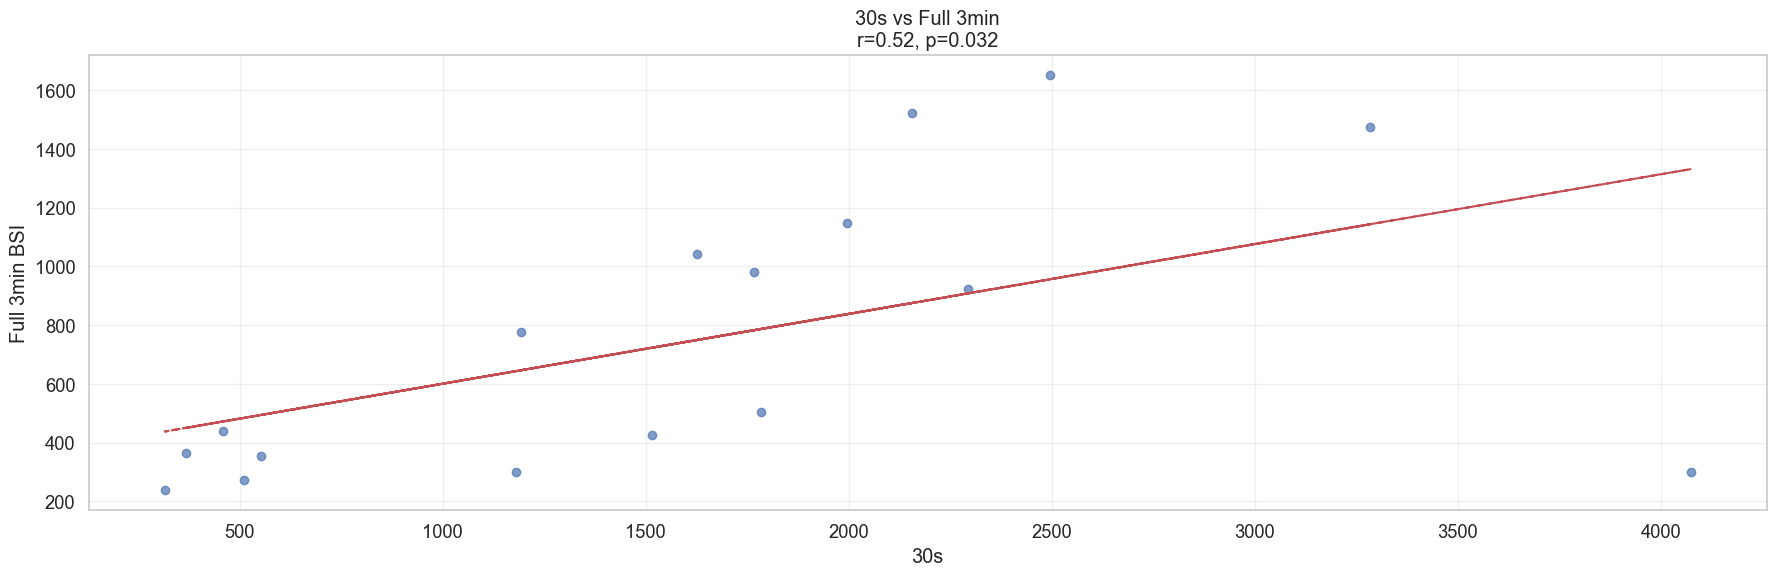

In [57]:
# Step 2: Initial Correlation Decision - Analyze GT data segments vs full recording
print("\nStep 2: Analyzing correlation between GT data segments and full recordings...")

# Prepare data structures to hold results
# Prepare data structures to hold results
segment_lengths = [30, 60]  # seconds
stride = 5  # seconds - step size between windows

# We'll group BSI values by segment length for easier analysis
gt_bsi_values = {
    '30s': [],
    'full': []
}

# Additional structure to store all window data
gt_bsi_all_windows = {}

subject_ids = []


# Calculate BSI for different segments of GT data
for subject_id, rr_intervals in gt_data.items():
    subject_ids.append(subject_id)
    
    for segment_length in segment_lengths:
        segments = segment_data(rr_intervals, segment_length,  stride=stride)
        
        # For full recording, store in the original structure
        if segment_length == 60:
            for segment_name, segment_rr_data in segments.items():
                if len(segment_rr_data) > 0:
                    bsi = compute_bsi(segment_rr_data)
                    gt_bsi_values['full'].append(bsi)
        else:
            # For windowed segments, collect all BSI values
            segment_bsis = []
            for segment_name, segment_rr_data in segments.items():
                if len(segment_rr_data) > 0:
                    bsi = compute_bsi(segment_rr_data)
                    segment_bsis.append(bsi)

            # Store the mean BSI for each segment length (or you could use median, min, max)
            if segment_bsis:
                if segment_length == 30:
                    gt_bsi_values['30s'].append(np.mean([b for b in segment_bsis if not np.isnan(b)]))
                
                # Also store all window data for potential detailed analysis
                key = f"{subject_id}_{segment_length}s"
                gt_bsi_all_windows[key] = segment_bsis

# Convert to arrays for easier analysis
for segment in ['30s', 'full']:
    ## Check the len of the segment
    print(f"Segment {segment} has {len(gt_bsi_values[segment])} values")
    gt_bsi_values[segment] = np.array(gt_bsi_values[segment])

# Apply outlier removal to each segment's BSI values
print("\nRemoving outliers from BSI values...")
for segment in ['30s', 'full']:
    # Only apply if we have enough data points
    if len(gt_bsi_values[segment]) > 5:
        gt_bsi_values[segment] = remove_outliers(gt_bsi_values[segment], method='IQR')
    else:
        print(f"Not enough data points to remove outliers for {segment} segment")

for segment in ['30s', 'full']:
    ## Check the len of the segment
    print(f"Segment {segment} has {len(gt_bsi_values[segment])} values")

## Truncate the segments to the same length
min_length = min(len(gt_bsi_values['30s']), len(gt_bsi_values['full']))
for segment in ['30s', 'full']:
    if len(gt_bsi_values[segment]) > min_length:
        gt_bsi_values[segment] = gt_bsi_values[segment][:min_length]
        print(f"Truncated {segment} to {len(gt_bsi_values[segment])} values")

# Use the refactored functions for correlation analysis
segment_names = ['30s', ]

# Compute correlations
bsi_correlations = compute_correlations(
    x_data=gt_bsi_values,
    y_data=gt_bsi_values['full'],
    segment_names=segment_names
)

# Plot correlations
plot_correlation_comparison(
    x_data=gt_bsi_values,
    y_data=gt_bsi_values['full'],
    segment_names=segment_names,
    correlations=bsi_correlations,
    title_prefix="",
    x_label_prefix="",
    y_label="Full 3min BSI"
)


Analyzing agreement with Bland-Altman plots...


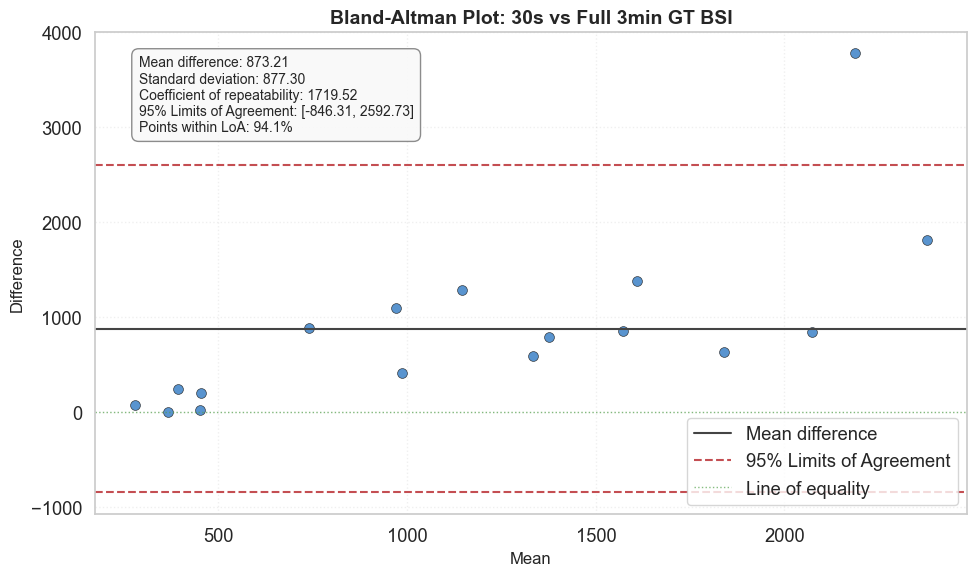

In [58]:
# Create individual Bland-Altman plots
create_individual_bland_altman_plots(
    x_data=gt_bsi_values,
    y_data=gt_bsi_values['full'],
    segment_names=segment_names,
    correlations=bsi_correlations
)


---

### Notes:

I've no idea regarding the outlier difference, so it's safe to say the HRV Time Features has good positive correlation

### Task 2: Plot the HRV Time Features Correlation Short and Full GT


Step 2: Analyzing HRV time features across different segment lengths...
Feature SDNN, Segment 30s has 20 values
Feature SDNN, Segment full has 20 values
Feature RMSSD, Segment 30s has 20 values
Feature RMSSD, Segment full has 20 values
Feature meanNN, Segment 30s has 20 values
Feature meanNN, Segment full has 20 values
Feature meanHR, Segment 30s has 20 values
Feature meanHR, Segment full has 20 values
Feature pNN50, Segment 30s has 20 values
Feature pNN50, Segment full has 20 values


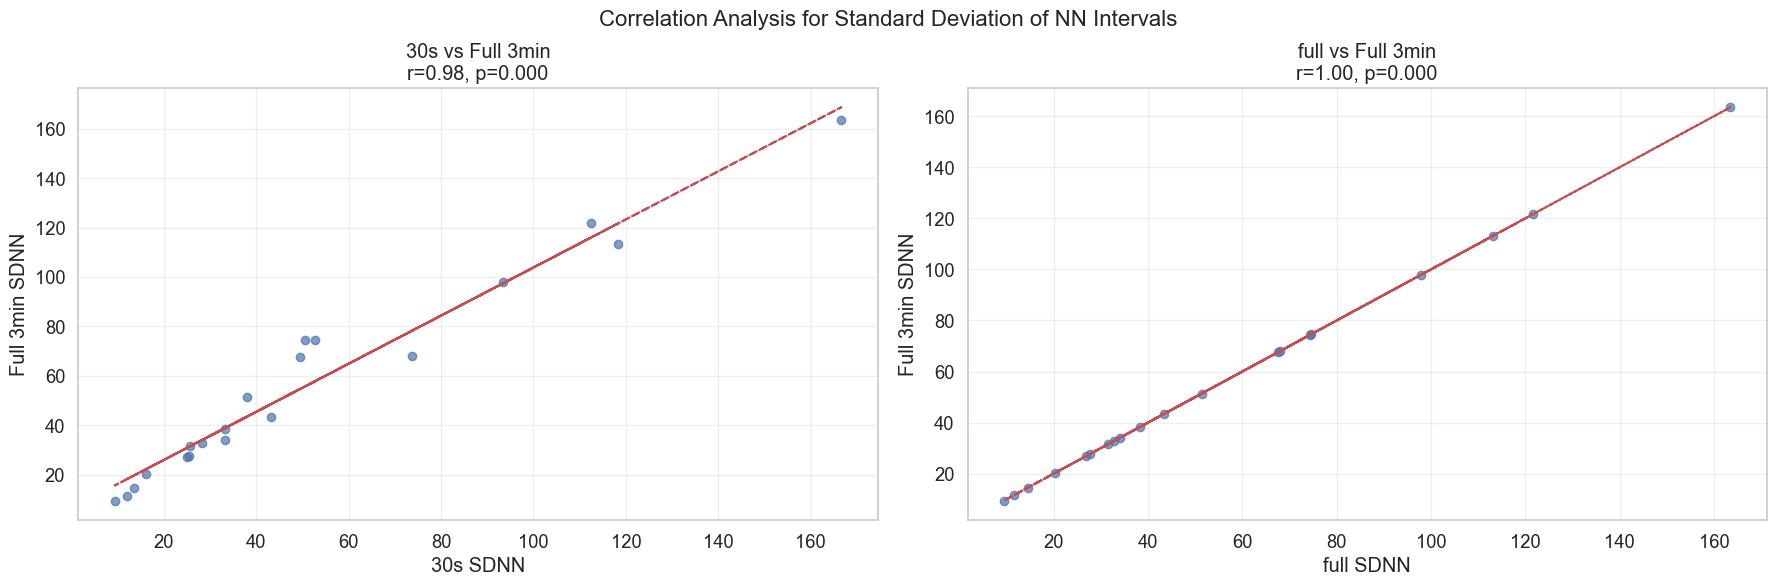

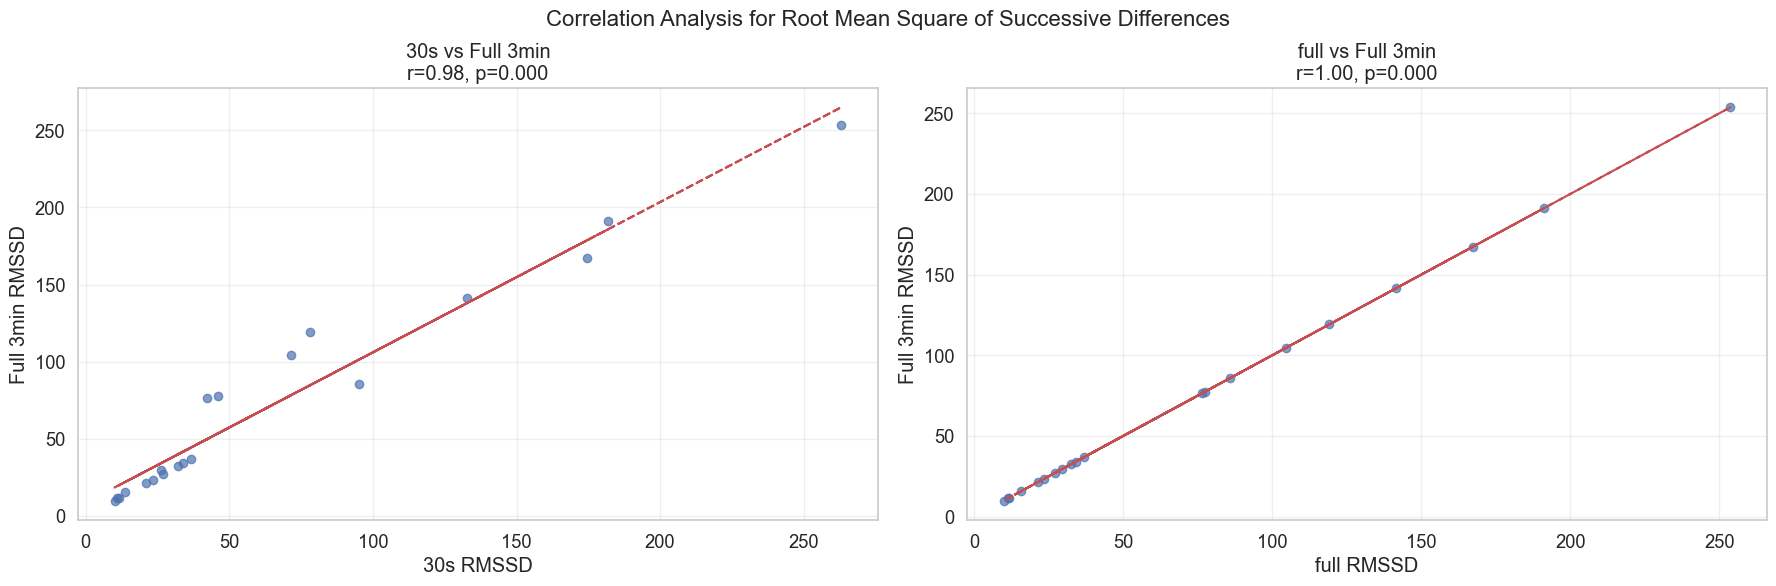

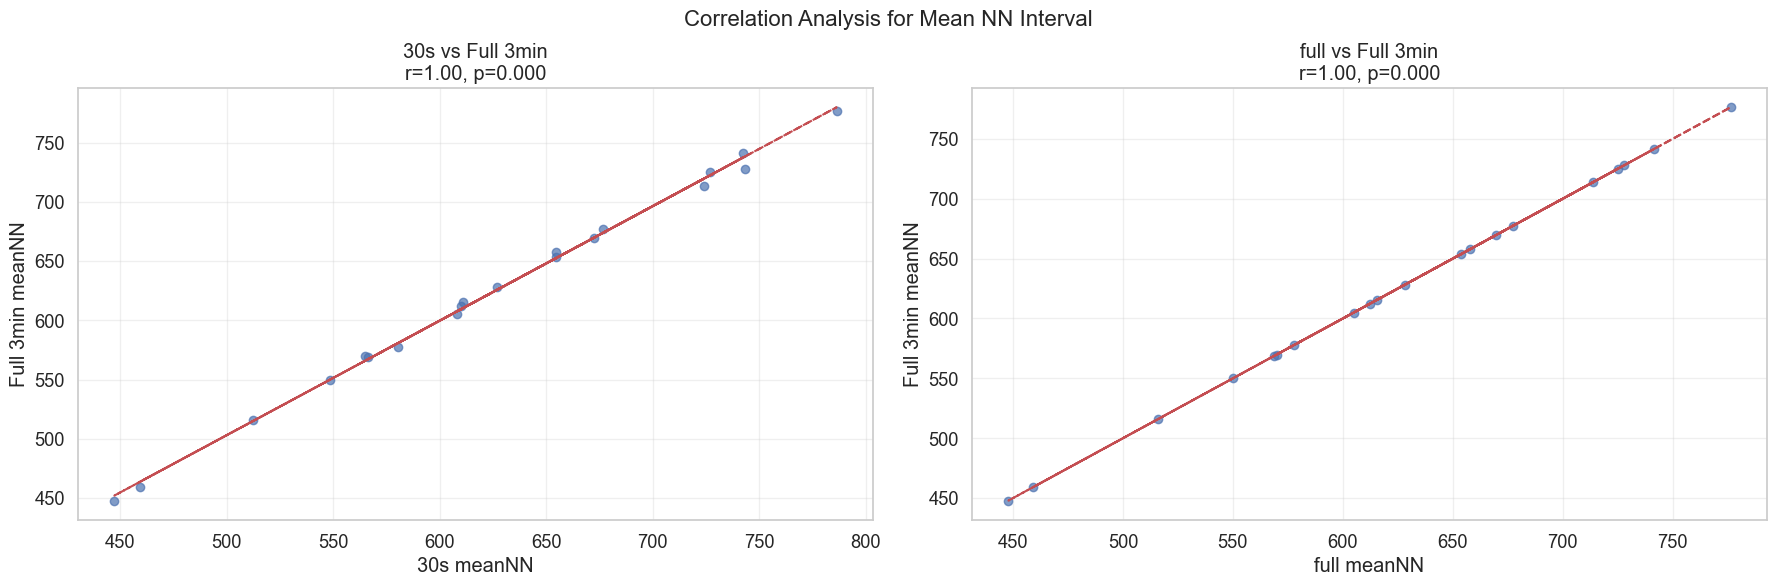

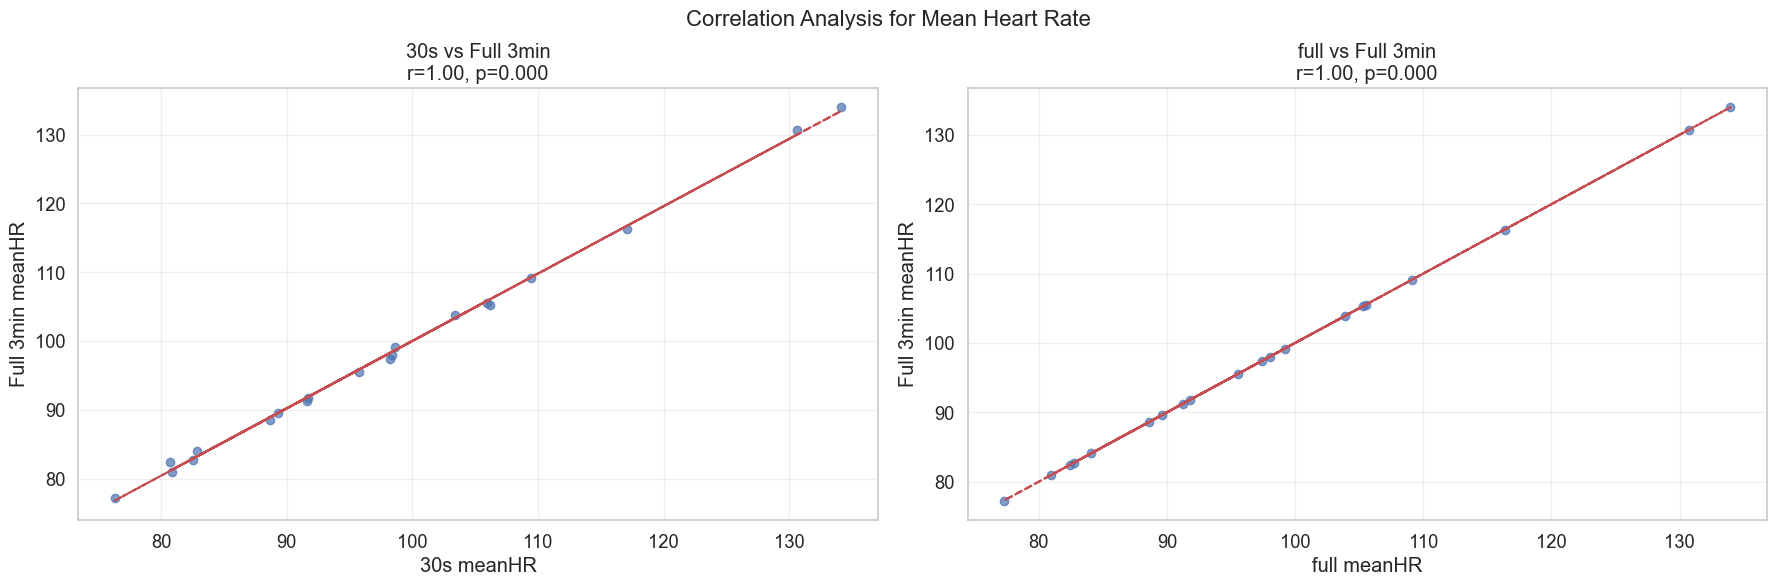

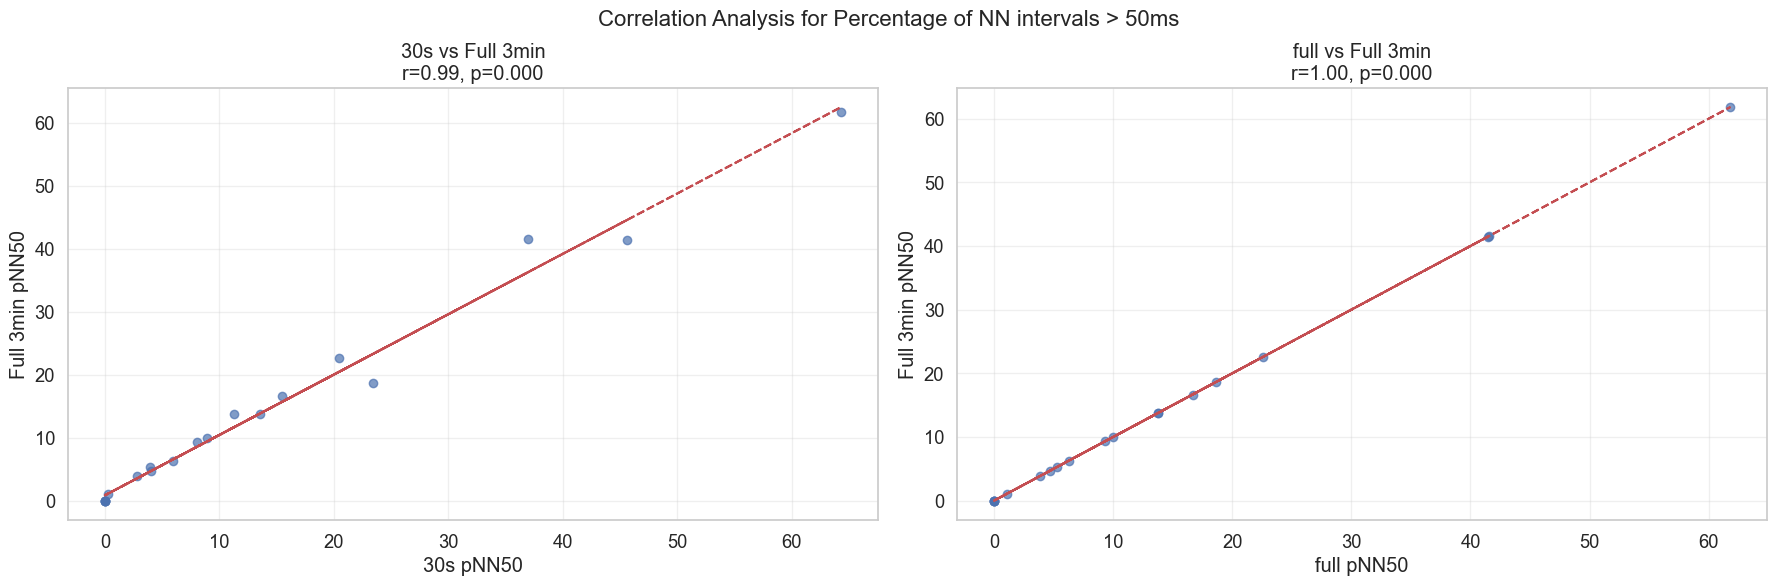


Generating Bland-Altman plots for all HRV features...

Analyzing agreement for Standard Deviation of NN Intervals...


KeyError: 'full'

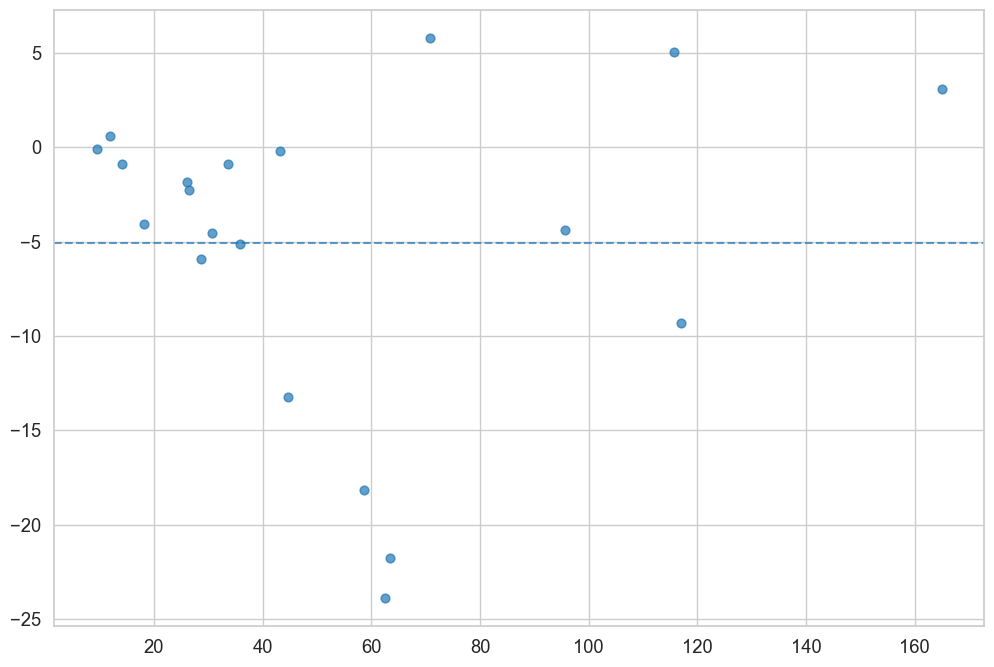

In [60]:
# Step 2: Analyze HRV time features across different segment lengths
print("\nStep 2: Analyzing HRV time features across different segment lengths...")

# Prepare data structures to hold results
segment_lengths = [30, 60]  # seconds
stride = 5  # seconds - step size between windows

# List of HRV time features to analyze
hrv_features = ['SDNN', 'RMSSD', 'meanNN', 'meanHR', 'pNN50']

segment_names = ['30s', "full"]

# We'll group HRV features by segment length for easier analysis
gt_hrv_values = {
    feature: {
        '30s': [],
        'full': []
    } for feature in hrv_features
}

# Additional structure to store all window data
gt_hrv_all_windows = {}

subject_ids = []

# Calculate HRV features for different segments of GT data
for subject_id, rr_intervals in gt_data.items():
    subject_ids.append(subject_id)
    
    for segment_length in segment_lengths:
        segments = segment_data(rr_intervals, segment_length, stride=stride)
        
        # For full recording, store in the original structure
        if segment_length == 60:
            for segment_name, segment_rr_data in segments.items():
                if len(segment_rr_data) > 0:
                    # Calculate all HRV features
                    hrv_data = compute_hrv_features(segment_rr_data)
                    for feature in hrv_features:
                        gt_hrv_values[feature]['full'].append(hrv_data[feature])
        else:
            # For windowed segments, collect all feature values
            segment_features = {feature: [] for feature in hrv_features}
            
            for segment_name, segment_rr_data in segments.items():
                if len(segment_rr_data) > 0:
                    # Calculate all HRV features for this window
                    hrv_data = compute_hrv_features(segment_rr_data)
                    
                    # Store each feature separately
                    for feature in hrv_features:
                        segment_features[feature].append(hrv_data[feature])
            
            # Store the mean value for each feature and segment length
            for feature in hrv_features:
                valid_values = [v for v in segment_features[feature] if not np.isnan(v)]
                if valid_values:
                    if segment_length == 30:
                        gt_hrv_values[feature]['30s'].append(np.mean(valid_values))
            
            # Also store all window data for potential detailed analysis
            key = f"{subject_id}_{segment_length}s"
            gt_hrv_all_windows[key] = segment_features

# Convert to arrays for easier analysis
for feature in hrv_features:
    for segment in ['30s', 'full']:
        print(f"Feature {feature}, Segment {segment} has {len(gt_hrv_values[feature][segment])} values")
        gt_hrv_values[feature][segment] = np.array(gt_hrv_values[feature][segment])

# # Apply outlier removal to each feature's values
# print("\nRemoving outliers from HRV features...")
# for feature in hrv_features:
#     for segment in ['30s', 'full']:
#         # Only apply if we have enough data points
#         if len(gt_hrv_values[feature][segment]) > 5:
#             gt_hrv_values[feature][segment] = remove_outliers(gt_hrv_values[feature][segment], method='IQR')
#         else:
#             print(f"Not enough data points to remove outliers for {feature} {segment}")

# ## Truncate the segments to the same length
# min_length = min(len(gt_hrv_values[feature]['30s']), len(gt_hrv_values[feature]['full']))
# print(len(gt_hrv_values[feature]['30s']))
# print(len(gt_hrv_values[feature]['full']))

# # Truncate the segments to the same length for each feature individually
# for feature in hrv_features:
#     # Calculate min_length for each feature
#     min_length = min(len(gt_hrv_values[feature]['30s']), len(gt_hrv_values[feature]['full']))
#     print(f"Feature {feature}: min_length = {min_length}")
    
#     # Truncate both segments to the same length
#     for segment in ['30s', 'full']:
#         if len(gt_hrv_values[feature][segment]) > min_length:
#             gt_hrv_values[feature][segment] = gt_hrv_values[feature][segment][:min_length]
#             print(f"Truncated {feature} {segment} to {len(gt_hrv_values[feature][segment])} values")

# Create a more informative display name mapping for features
feature_display_names = {
    'SDNN': 'Standard Deviation of NN Intervals',
    'RMSSD': 'Root Mean Square of Successive Differences',
    'meanNN': 'Mean NN Interval',
    'meanHR': 'Mean Heart Rate',
    'pNN50': 'Percentage of NN intervals > 50ms'
}

# Compute correlations for each HRV feature
feature_correlations = compute_feature_correlations(
    feature_data=gt_hrv_values,
    segment_names=segment_names
)

# # Display summary table of correlations for all features
# summarize_feature_correlations(
#     feature_correlations=feature_correlations,
#     hrv_features=hrv_features,
#     segment_names=segment_names,
#     feature_display_names=feature_display_names
# )

# Plot correlations for all HRV features
plot_all_feature_correlations(
    feature_data=gt_hrv_values,
    feature_correlations=feature_correlations,
    hrv_features=hrv_features,
    feature_display_names=feature_display_names,
    segment_names=segment_names
)

# Create Bland-Altman plots for all features
create_feature_bland_altman_plots(
    feature_data=gt_hrv_values,
    hrv_features=hrv_features,
    feature_correlations=feature_correlations,
    segment_names=segment_names,
    feature_display_names=feature_display_names
)


---

### Task 3: rPPG Mapping Correlation BSI, rPPG Short vs Full GT

In [63]:
def compute_method_correlations(method_data, reference_data, segment_names):
    """
    Compute correlations between method data segments and reference data.
    
    Parameters:
    -----------
    method_data : dict
        Dictionary with segment names as keys and numpy arrays as values
    reference_data : numpy.ndarray
        Reference data to compare against (e.g., full ground truth data)
    segment_names : list
        List of segment names to process
        
    Returns:
    --------
    dict
        Dictionary of correlation results with segment names as keys
    """
    correlations = {}
    
    for segment in segment_names:
        # Ensure equal lengths for comparison
        min_len = min(len(method_data[segment]), len(reference_data))
        
        if min_len > 1:  # Need at least a few valid points
            # Create mask for valid values (non-NaN)
            mask = ~np.isnan(method_data[segment][:min_len]) & ~np.isnan(reference_data[:min_len])
            
            if sum(mask) > 1:
                corr, p_value = stats.pearsonr(
                    method_data[segment][:min_len][mask],
                    reference_data[:min_len][mask]
                )
                
                correlations[segment] = {
                    'pearson_r': corr,
                    'p_value': p_value,
                    'valid_points': sum(mask)
                }
    
    return correlations



Step 3: Comparing all rPPG methods against ground truth...

Analyzing POS rPPG method...
  POS Segment 30s has 20 values
  POS Segment full has 20 values

Analyzing LGI rPPG method...
  LGI Segment 30s has 20 values
  LGI Segment full has 20 values

Analyzing OMIT rPPG method...
  OMIT Segment 30s has 20 values
  OMIT Segment full has 20 values

Analyzing GREEN rPPG method...
  GREEN Segment 30s has 20 values
  GREEN Segment full has 20 values

Analyzing CHROM rPPG method...
  CHROM Segment 30s has 20 values
  CHROM Segment full has 20 values


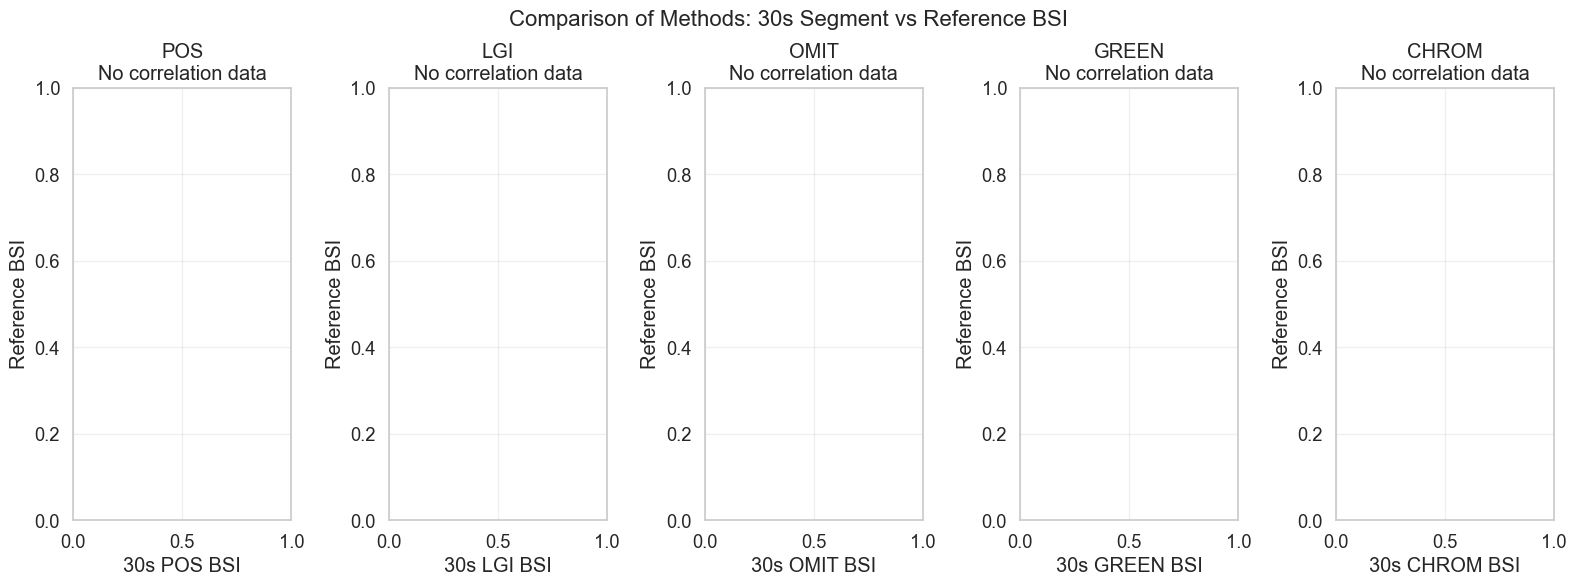

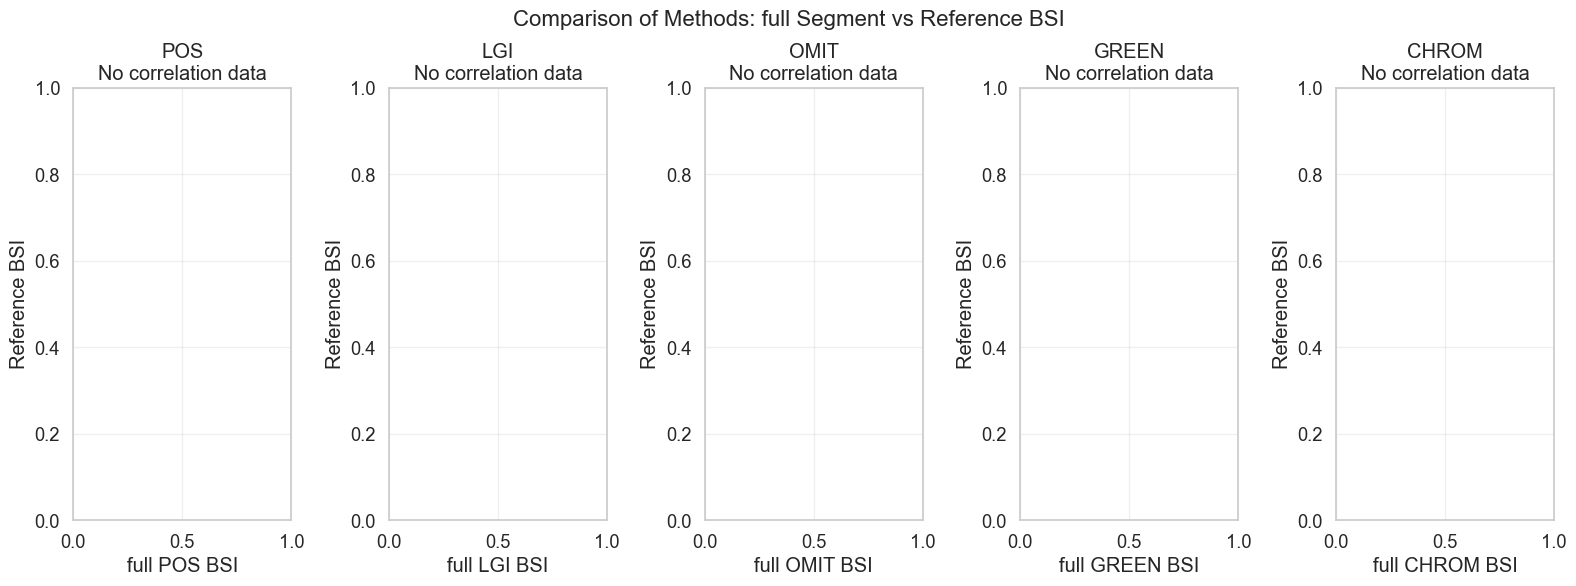


Best Methods for BSI by Segment Length:
  30s: No valid method found
  full: No valid method found

Generating Bland-Altman plots for best methods...


In [64]:
# Step 3: Analyze and compare all rPPG methods vs full GT recording
print("\nStep 3: Comparing all rPPG methods against ground truth...")

# List all available rPPG methods
rppg_methods = ['POS', 'LGI', 'OMIT', 'GREEN', 'CHROM']
segment_lengths = [30, 60]  # seconds
stride = 5  # seconds

# Create a structure to store results for all methods
all_rppg_results = {}

# Process each rPPG method 
for rppg_method in rppg_methods:
    print(f"\nAnalyzing {rppg_method} rPPG method...")
    
    # We'll group BSI values by segment length for easier analysis
    rppg_bsi_values = {
        '30s': [],
        'full': []
    }
    
    # Additional structure to store all window data
    rppg_bsi_all_windows = {}
    
    subject_ids = []
    
    # Calculate BSI for different segments of rPPG data
    for subject_id, rr_intervals in rppg_data[rppg_method].items():
        subject_ids.append(subject_id)
        
        for segment_length in segment_lengths:
            segments = segment_data(rr_intervals, segment_length, stride=stride)
            
            # For full recording, store in the original structure
            if segment_length == 60:
                for segment_name, segment_rr_data in segments.items():
                    if len(segment_rr_data) > 0:
                        bsi = compute_bsi(segment_rr_data)
                        rppg_bsi_values['full'].append(bsi)
            else:
                # For windowed segments, collect all BSI values
                segment_bsis = []
                for segment_name, segment_rr_data in segments.items():
                    if len(segment_rr_data) > 0:
                        bsi = compute_bsi(segment_rr_data)
                        segment_bsis.append(bsi)
                
                # Store the mean BSI for each segment length
                if segment_bsis:
                    if segment_length == 30:
                        rppg_bsi_values['30s'].append(np.mean([b for b in segment_bsis if not np.isnan(b)]))
                    
                    # Also store all window data for potential detailed analysis
                    key = f"{subject_id}_{segment_length}s"
                    rppg_bsi_all_windows[key] = segment_bsis
    
    # Convert to arrays for easier analysis
    for segment in ['30s', 'full']:
        print(f"  {rppg_method} Segment {segment} has {len(rppg_bsi_values[segment])} values")
        rppg_bsi_values[segment] = np.array(rppg_bsi_values[segment])
    
    # Apply outlier removal to each segment's BSI values
    # print(f"\n  Removing outliers from {rppg_method} BSI values...")
    # for segment in ['30s', 'full']:
    #     # Only apply if we have enough data points
    #     if len(rppg_bsi_values[segment]) > 5:
    #         rppg_bsi_values[segment] = remove_outliers(rppg_bsi_values[segment], method='IQR')
    #     else:
    #         print(f"  Not enough data points to remove outliers for {segment} segment")
    
    # We need to get the full GT BSI values to compare against if we haven't already
    if 'gt_full_bsi' not in locals():
        gt_full_bsi = []
        for subject_id in subject_ids:
            if subject_id in gt_data:
                # Calculate full recording BSI for ground truth
                rr_intervals = gt_data[subject_id]
                segments = segment_data(rr_intervals, 180)  # Full recording
                for segment_name, segment_rr_data in segments.items():
                    if len(segment_rr_data) > 0:
                        bsi = compute_bsi(segment_rr_data)
                        gt_full_bsi.append(bsi)
                        break  # Should only be one segment for full recording
        
        # Convert to array
        gt_full_bsi = np.array(gt_full_bsi)
    
    # Calculate correlations using the new function
    correlations = compute_method_correlations(
        method_data=rppg_bsi_values,
        reference_data=gt_full_bsi,
        segment_names=segment_names
    )
    
    # Store results for this method
    all_rppg_results[rppg_method] = {
        'bsi_values': rppg_bsi_values,
        'correlations': correlations,
        'windows': rppg_bsi_all_windows
    }

# Create all comparison plots using the new function
plot_method_comparisons(
    results_dict=all_rppg_results,
    reference_data=gt_full_bsi,
    segment_names=segment_names,
    method_names=rppg_methods,
    feature_name="BSI",
    plot_bland_altman=True
)

---

### Task 4: Plot correlation short rPPG vs Full GT HRV values


Step 3: Comparing all rPPG methods against ground truth for HRV features...

Analyzing POS rPPG method...
  POS SDNN 30s has 20 values
  POS SDNN full has 20 values
  POS RMSSD 30s has 20 values
  POS RMSSD full has 20 values
  POS meanNN 30s has 20 values
  POS meanNN full has 20 values
  POS meanHR 30s has 20 values
  POS meanHR full has 20 values
  POS pNN50 30s has 20 values
  POS pNN50 full has 20 values
  POS BSI 30s has 20 values
  POS BSI full has 20 values

Analyzing LGI rPPG method...
  LGI SDNN 30s has 20 values
  LGI SDNN full has 20 values
  LGI RMSSD 30s has 20 values
  LGI RMSSD full has 20 values
  LGI meanNN 30s has 20 values
  LGI meanNN full has 20 values
  LGI meanHR 30s has 20 values
  LGI meanHR full has 20 values
  LGI pNN50 30s has 20 values
  LGI pNN50 full has 20 values
  LGI BSI 30s has 20 values
  LGI BSI full has 20 values

Analyzing OMIT rPPG method...
  OMIT SDNN 30s has 20 values
  OMIT SDNN full has 20 values
  OMIT RMSSD 30s has 20 values
  OMIT RMSSD

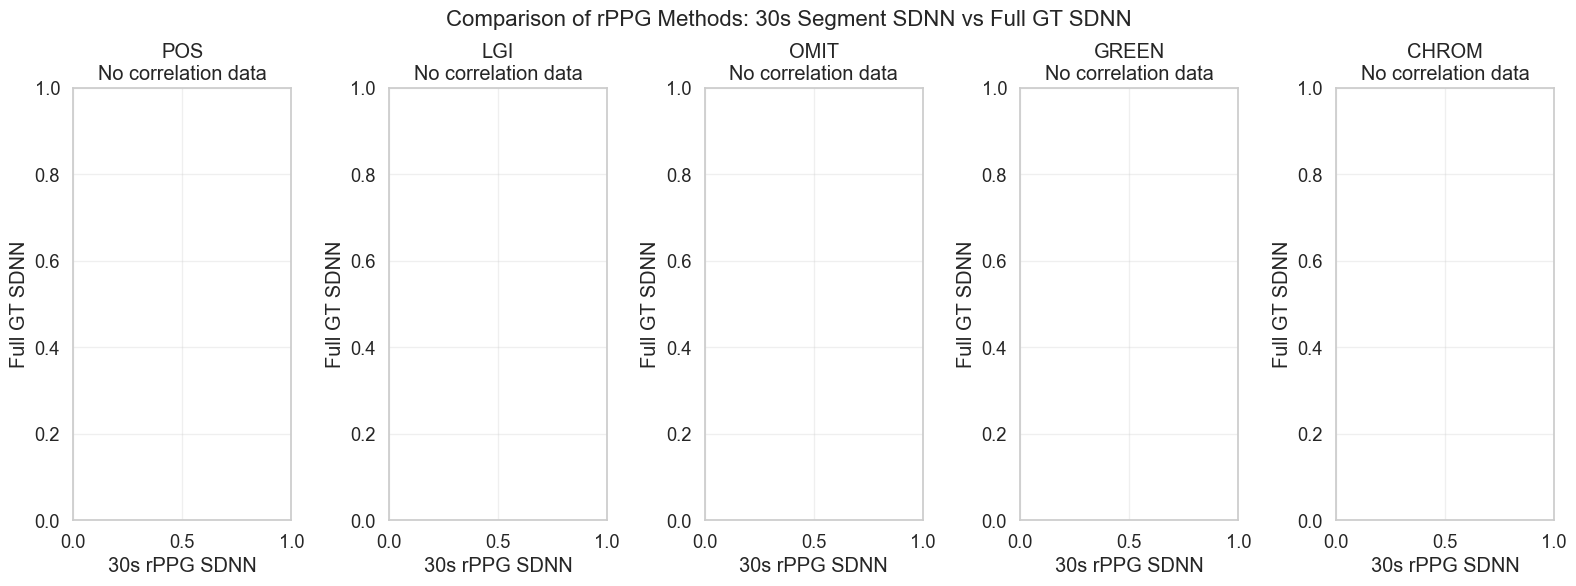

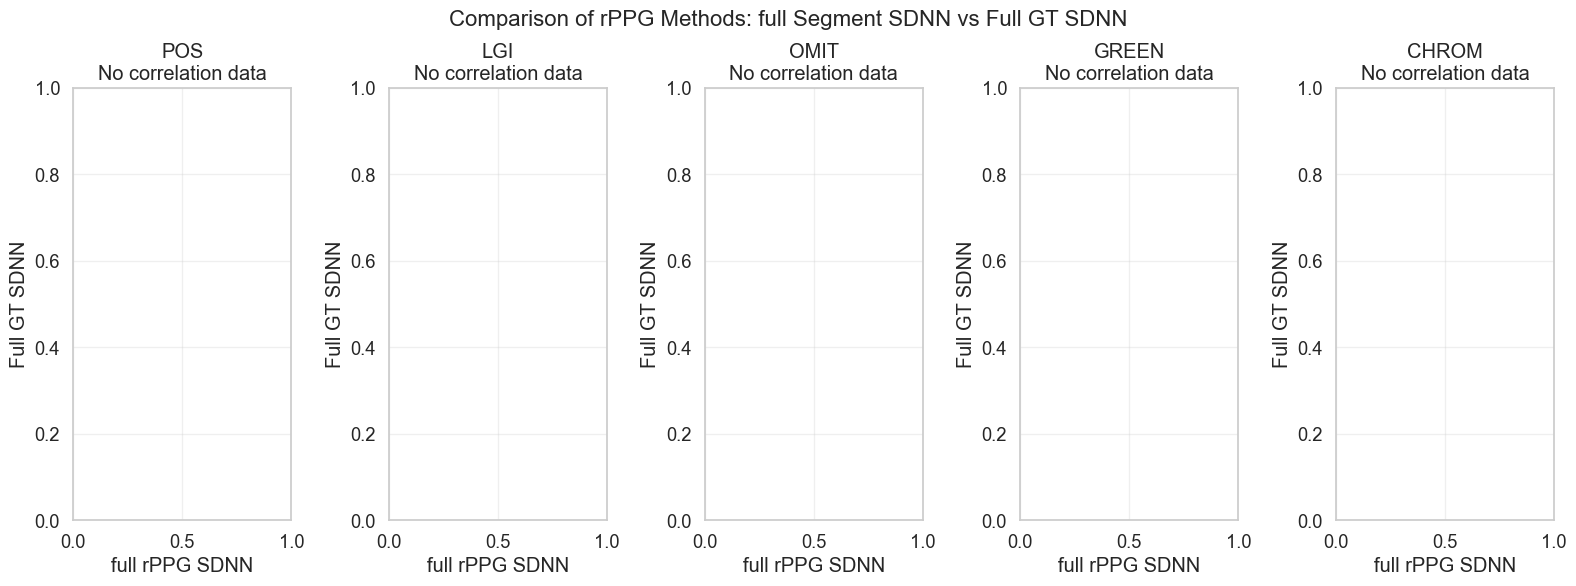


Analyzing Root Mean Square of Successive Differences...


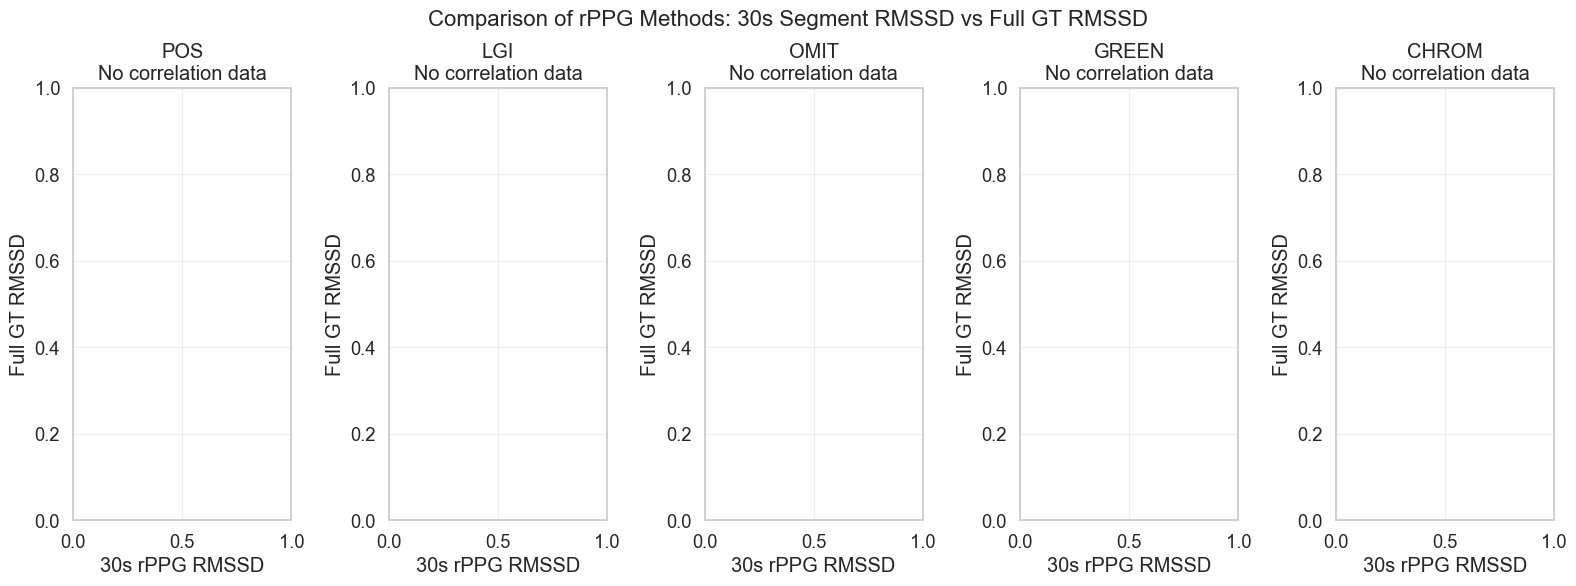

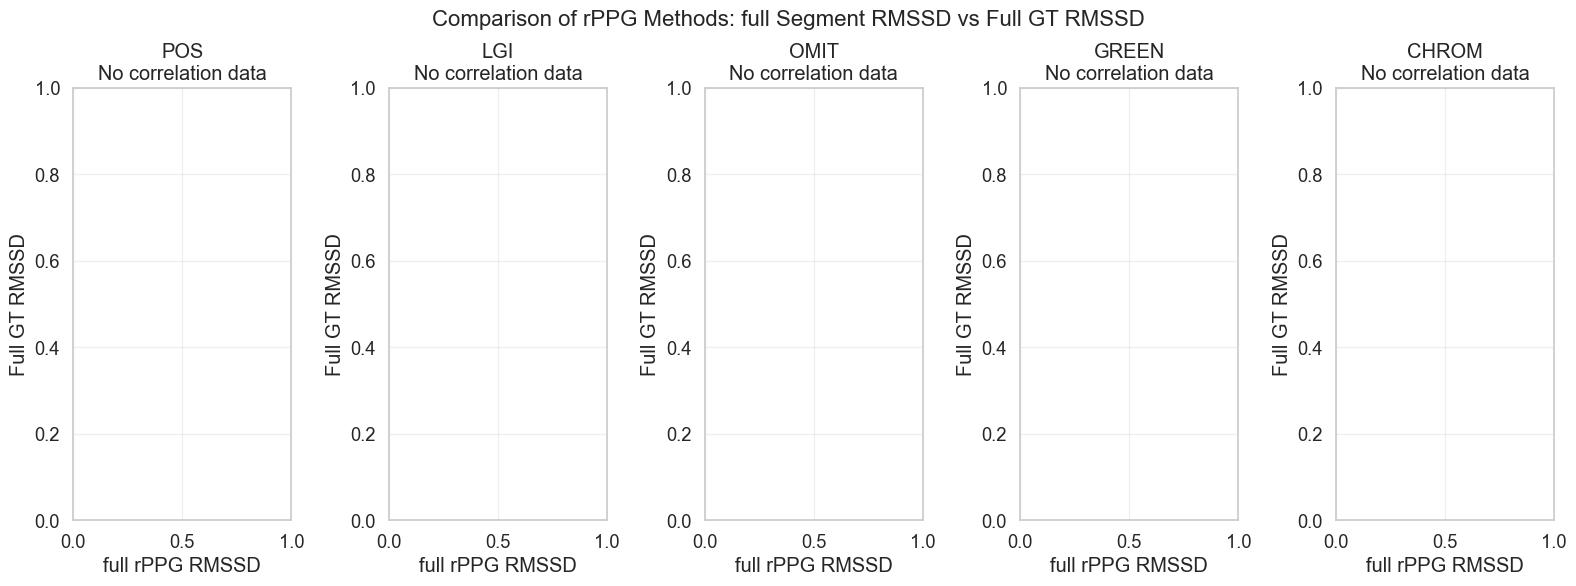


Analyzing Mean NN Interval...


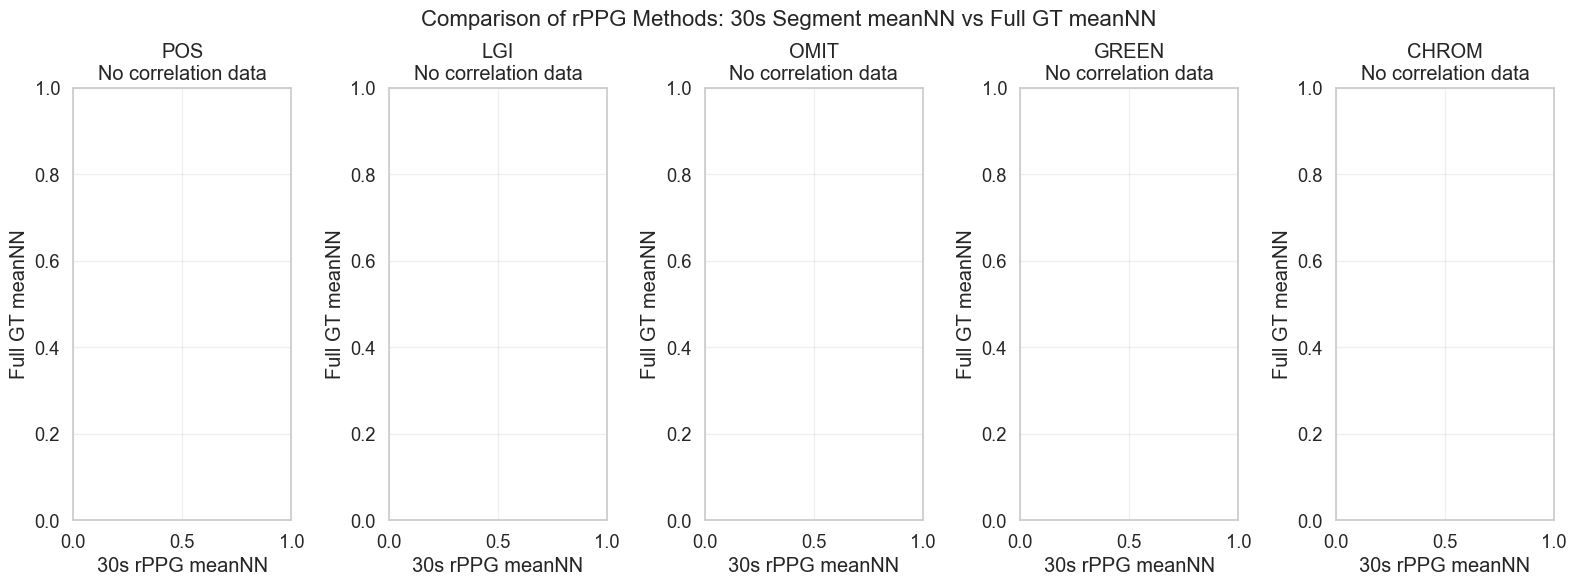

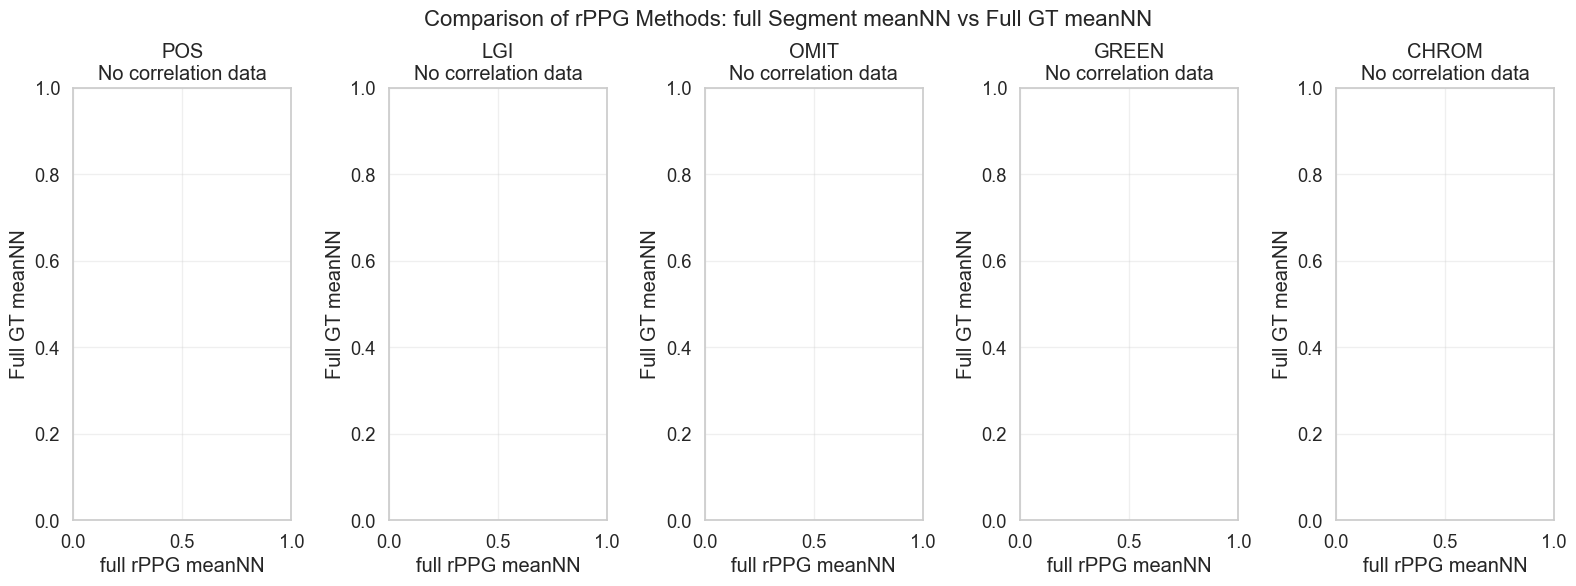


Best rPPG Methods for Standard Deviation of NN Intervals by Segment Length:
  30s: No valid method found
  full: No valid method found

Best rPPG Methods for Root Mean Square of Successive Differences by Segment Length:
  30s: No valid method found
  full: No valid method found

Best rPPG Methods for Mean NN Interval by Segment Length:
  30s: No valid method found
  full: No valid method found

Generating Bland-Altman plots for SDNN...

Generating Bland-Altman plots for RMSSD...

Generating Bland-Altman plots for meanNN...

COMPREHENSIVE HRV FEATURE ANALYSIS SUMMARY

Overall best feature/method/segment combinations:

Insufficient data to make a clear recommendation.


In [65]:
# Step 3: Analyze and compare all rPPG methods vs full GT recording for HRV features
print("\nStep 3: Comparing all rPPG methods against ground truth for HRV features...")

# List all available rPPG methods
rppg_methods = ['POS', 'LGI', 'OMIT', 'GREEN', 'CHROM']
segment_lengths = [30, 60]  # seconds
stride = 5  # seconds

# List of HRV features to analyze
hrv_features = ['SDNN', 'RMSSD', 'meanNN', 'meanHR', 'pNN50', 'BSI']

# Create a structure to store results for all methods and features
all_rppg_results = {}

# Process each rPPG method 
for rppg_method in rppg_methods:
    print(f"\nAnalyzing {rppg_method} rPPG method...")
    
    # Initialize structure to store HRV feature values for this method
    rppg_hrv_values = {
        feature: {
            '30s': [],
            '1min': [],
            '2min': [],
            'full': []
        } for feature in hrv_features
    }
    
    # Additional structure to store all window data
    rppg_hrv_all_windows = {feature: {} for feature in hrv_features}
    
    subject_ids = []
    
    # Calculate HRV features for different segments of rPPG data
    for subject_id, rr_intervals in rppg_data[rppg_method].items():
        subject_ids.append(subject_id)
        
        for segment_length in segment_lengths:
            segments = segment_data(rr_intervals, segment_length, stride=stride)
            
            # For full recording, store in the original structure
            if segment_length == 60:
                for segment_name, segment_rr_data in segments.items():
                    if len(segment_rr_data) > 0:
                        # Calculate all HRV features
                        hrv_data = compute_hrv_features(segment_rr_data)
                        for feature in hrv_features:
                            rppg_hrv_values[feature]['full'].append(hrv_data[feature])
            else:
                # For windowed segments, collect all feature values
                segment_features = {feature: [] for feature in hrv_features}
                
                for segment_name, segment_rr_data in segments.items():
                    if len(segment_rr_data) > 0:
                        # Calculate all HRV features for this window
                        hrv_data = compute_hrv_features(segment_rr_data)
                        
                        # Store each feature separately
                        for feature in hrv_features:
                            segment_features[feature].append(hrv_data[feature])
                
                # Store the mean value for each feature and segment length
                for feature in hrv_features:
                    valid_values = [v for v in segment_features[feature] if not np.isnan(v)]
                    if valid_values:
                        if segment_length == 30:
                            rppg_hrv_values[feature]['30s'].append(np.mean(valid_values))
                
                # Also store all window data for potential detailed analysis
                for feature in hrv_features:
                    key = f"{subject_id}_{segment_length}s"
                    if key not in rppg_hrv_all_windows[feature]:
                        rppg_hrv_all_windows[feature][key] = segment_features[feature]
    
    # Convert to arrays for easier analysis
    for feature in hrv_features:
        for segment in ['30s', 'full']:
            print(f"  {rppg_method} {feature} {segment} has {len(rppg_hrv_values[feature][segment])} values")
            rppg_hrv_values[feature][segment] = np.array(rppg_hrv_values[feature][segment])
    
    # # Apply outlier removal to each feature's values
    # print(f"\n  Removing outliers from {rppg_method} HRV values...")
    # for feature in hrv_features:
    #     for segment in ['30s', '1min', '2min', 'full']:
    #         # Only apply if we have enough data points
    #         if len(rppg_hrv_values[feature][segment]) > 5:
    #             rppg_hrv_values[feature][segment] = remove_outliers(rppg_hrv_values[feature][segment], method='IQR')
    #         else:
    #             print(f"  Not enough data points to remove outliers for {feature} {segment} segment")
    
    # We need to get the full GT feature values to compare against if we haven't already
    if 'gt_full_hrv' not in locals():
        gt_full_hrv = {feature: [] for feature in hrv_features}
        
        for subject_id in subject_ids:
            if subject_id in gt_data:
                # Calculate full recording HRV features for ground truth
                rr_intervals = gt_data[subject_id]
                segments = segment_data(rr_intervals, 180)  # Full recording
                for segment_name, segment_rr_data in segments.items():
                    if len(segment_rr_data) > 0:
                        hrv_data = compute_hrv_features(segment_rr_data)
                        for feature in hrv_features:
                            gt_full_hrv[feature].append(hrv_data[feature])
                        break  # Should only be one segment for full recording
        
        # Convert to arrays
        for feature in hrv_features:
            gt_full_hrv[feature] = np.array(gt_full_hrv[feature])
    
    # Calculate correlations between rPPG segments and full GT features
    correlations = {feature: {} for feature in hrv_features}
    
    for feature in hrv_features:
        for segment in ['30s', 'full']:
            # Ensure equal lengths for comparison
            min_len = min(len(rppg_hrv_values[feature][segment]), len(gt_full_hrv[feature]))
            if min_len > 3:  # Need at least a few valid points
                # Use only valid values for correlation
                mask = ~np.isnan(rppg_hrv_values[feature][segment][:min_len]) & ~np.isnan(gt_full_hrv[feature][:min_len])
                if sum(mask) > 3:
                    corr, p_value = stats.pearsonr(
                        rppg_hrv_values[feature][segment][:min_len][mask], 
                        gt_full_hrv[feature][:min_len][mask]
                    )
                    correlations[feature][segment] = {
                        'pearson_r': corr,
                        'p_value': p_value
                    }
    
    # Store results for this method
    all_rppg_results[rppg_method] = {
        'hrv_values': rppg_hrv_values,
        'correlations': correlations,
        'windows': rppg_hrv_all_windows
    }

# Feature display names for better plots
feature_display_names = {
    'SDNN': 'Standard Deviation of NN Intervals',
    'RMSSD': 'Root Mean Square of Successive Differences',
    'meanNN': 'Mean NN Interval',
    'meanHR': 'Mean Heart Rate',
    'pNN50': 'Percentage of NN intervals > 50ms',
    'BSI': 'Baevsky Stress Index'
}

# Create a comparison plot for each HRV feature across methods
segment_names = ['30s', 'full']

# Select the top 3 most promising features based on average correlation
feature_avg_corr = {}
for feature in hrv_features:
    r_values = []
    for method in rppg_methods:
        for segment in segment_names:
            if segment in all_rppg_results[method]['correlations'][feature]:
                r_values.append(abs(all_rppg_results[method]['correlations'][feature][segment]['pearson_r']))
    feature_avg_corr[feature] = np.mean(r_values) if r_values else 0

# Sort features by average correlation
sorted_features = sorted(feature_avg_corr.items(), key=lambda x: x[1], reverse=True)
top_features = [f[0] for f in sorted_features[:3]]  # Top 3 features

print(f"\nTop 3 features with best average correlation: {top_features}")

# Plot correlations for top features
for feature in top_features:
    print(f"\nAnalyzing {feature_display_names[feature]}...")
    
    for segment in segment_names:
        plt.figure(figsize=(16, 6))
        plt.suptitle(f"Comparison of rPPG Methods: {segment} Segment {feature} vs Full GT {feature}", fontsize=16)
        
        # Scatterplots for each method
        for i, rppg_method in enumerate(rppg_methods):
            plt.subplot(1, len(rppg_methods), i+1)
            
            if segment in all_rppg_results[rppg_method]['correlations'][feature]:
                # Get data
                rppg_feature = all_rppg_results[rppg_method]['hrv_values'][feature][segment]
                
                # Use only valid values for plotting
                min_len = min(len(rppg_feature), len(gt_full_hrv[feature]))
                mask = ~np.isnan(rppg_feature[:min_len]) & ~np.isnan(gt_full_hrv[feature][:min_len])
                
                if sum(mask) > 3:
                    x = rppg_feature[:min_len][mask]
                    y = gt_full_hrv[feature][:min_len][mask]
                    
                    plt.scatter(x, y, alpha=0.7)
                    
                    # Add best fit line if we have enough points
                    if len(x) > 1:
                        m, b = np.polyfit(x, y, 1)
                        plt.plot(x, m*x + b, 'r--')
                    
                    corr = all_rppg_results[rppg_method]['correlations'][feature][segment]['pearson_r']
                    p_val = all_rppg_results[rppg_method]['correlations'][feature][segment]['p_value']
                    plt.title(f"{rppg_method}\nr={corr:.2f}, p={p_val:.3f}")
                else:
                    plt.title(f"{rppg_method}\nInsufficient data")
            else:
                plt.title(f"{rppg_method}\nNo correlation data")
                
            plt.xlabel(f"{segment} rPPG {feature}")
            plt.ylabel(f"Full GT {feature}")
            plt.grid(True, alpha=0.3)
    
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

# Find the best method for each feature and segment length
best_methods = {feature: {} for feature in top_features}

for feature in top_features:
    for segment in segment_names:
        best_corr = 0
        best_method = None
        
        for method in rppg_methods:
            if segment in all_rppg_results[method]['correlations'][feature]:
                corr = abs(all_rppg_results[method]['correlations'][feature][segment]['pearson_r'])
                if corr > best_corr:
                    best_corr = corr
                    best_method = method
        
        best_methods[feature][segment] = (best_method, best_corr)

# Display summary of best methods for each feature
for feature in top_features:
    print(f"\nBest rPPG Methods for {feature_display_names[feature]} by Segment Length:")
    for segment, (method, corr) in best_methods[feature].items():
        if method:
            print(f"  {segment}: {method} (r={corr:.2f})")
        else:
            print(f"  {segment}: No valid method found")

# Generate Bland-Altman plots for the best method in each segment for each feature
for feature in top_features:
    print(f"\nGenerating Bland-Altman plots for {feature}...")
    
    for segment, (method, _) in best_methods[feature].items():
        if method:
            print(f"  Creating Bland-Altman plot for {method} method, {segment} segment, {feature} feature")
            
            rppg_feature = all_rppg_results[method]['hrv_values'][feature][segment]
            min_len = min(len(rppg_feature), len(gt_full_hrv[feature]))
            mask = ~np.isnan(rppg_feature[:min_len]) & ~np.isnan(gt_full_hrv[feature][:min_len])
            
            if sum(mask) > 3:
                bland_altman_plot(
                    rppg_feature[:min_len][mask],
                    gt_full_hrv[feature][:min_len][mask],
                    f"Bland-Altman Plot: {method} {segment} rPPG {feature} vs Full GT {feature}",
                    segment_name=f"{method}_{segment}_{feature}_vs_GT",
                    ylabel=f"Difference (rPPG - GT) {feature}",
                    xlabel=f"Mean {feature}"
                )
                plt.show()

# Create a comprehensive summary
print("\n" + "="*50)
print("COMPREHENSIVE HRV FEATURE ANALYSIS SUMMARY")
print("="*50)

# Overall best feature & method combinations
best_overall = {}
for feature in top_features:
    # Find best segment/method combo for this feature
    best_r = 0
    best_combo = None
    
    for segment in segment_names:
        if segment in best_methods[feature]:
            method, r = best_methods[feature][segment]
            if r > best_r:
                best_r = r
                best_combo = (method, segment, r)
    
    if best_combo:
        best_overall[feature] = best_combo

# Sort by correlation
sorted_best = sorted(best_overall.items(), key=lambda x: x[1][2], reverse=True)

print("\nOverall best feature/method/segment combinations:")
for feature, (method, segment, r) in sorted_best:
    print(f"  {feature_display_names[feature]}: {method} method, {segment} segment (r={r:.2f})")

# Final recommendation
if sorted_best:
    top_feature, (top_method, top_segment, top_r) = sorted_best[0]
    print(f"\nRECOMMENDATION: Use {feature_display_names[top_feature]} with {top_method} rPPG method and {top_segment} segment length.")
    print(f"  Correlation with ground truth: r={top_r:.2f}")
else:
    print("\nInsufficient data to make a clear recommendation.")

---

---

### Trivia 

### Task 5: rPPG short vs rppg full with BSI


Analyzing correlation between short-term rPPG and full-length rPPG...

Analyzing POS rPPG method...
  POS Segment 30s has 20 values
  POS Segment full has 20 values

  Removing outliers from POS BSI values...

Analyzing LGI rPPG method...
  LGI Segment 30s has 20 values
  LGI Segment full has 20 values

  Removing outliers from LGI BSI values...

Analyzing OMIT rPPG method...
  OMIT Segment 30s has 20 values
  OMIT Segment full has 20 values

  Removing outliers from OMIT BSI values...

Analyzing GREEN rPPG method...
  GREEN Segment 30s has 20 values
  GREEN Segment full has 20 values

  Removing outliers from GREEN BSI values...

Analyzing CHROM rPPG method...
  CHROM Segment 30s has 20 values
  CHROM Segment full has 20 values

  Removing outliers from CHROM BSI values...
Removed 1 outliers using IQR method


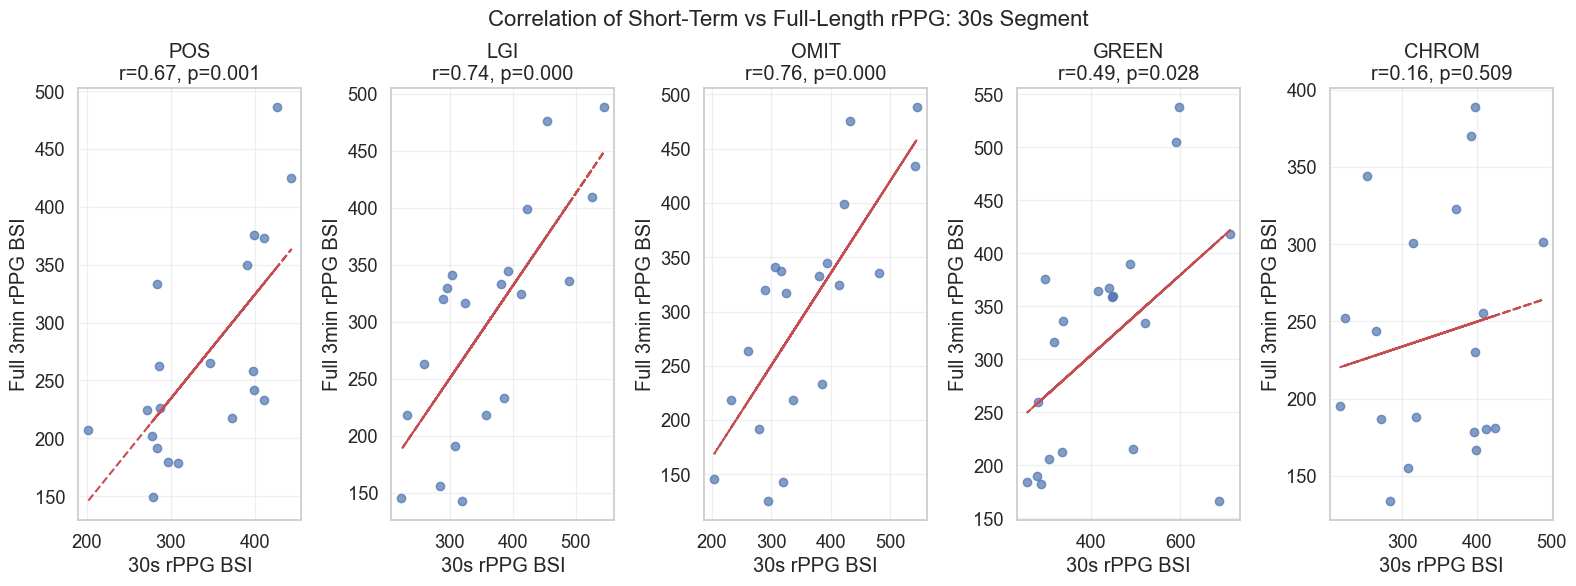

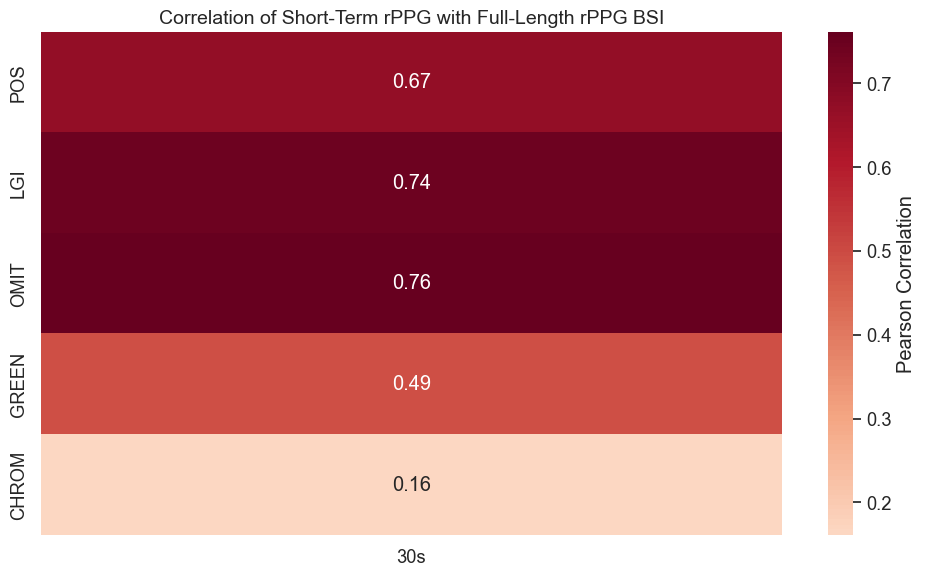


Best segment length for each rPPG method:
  POS: 30s (r=0.67)
  LGI: 30s (r=0.74)
  OMIT: 30s (r=0.76)
  GREEN: 30s (r=0.49)
  CHROM: 30s (r=0.16)

Generating Bland-Altman plots...
  Creating Bland-Altman plot for POS method, 30s segment


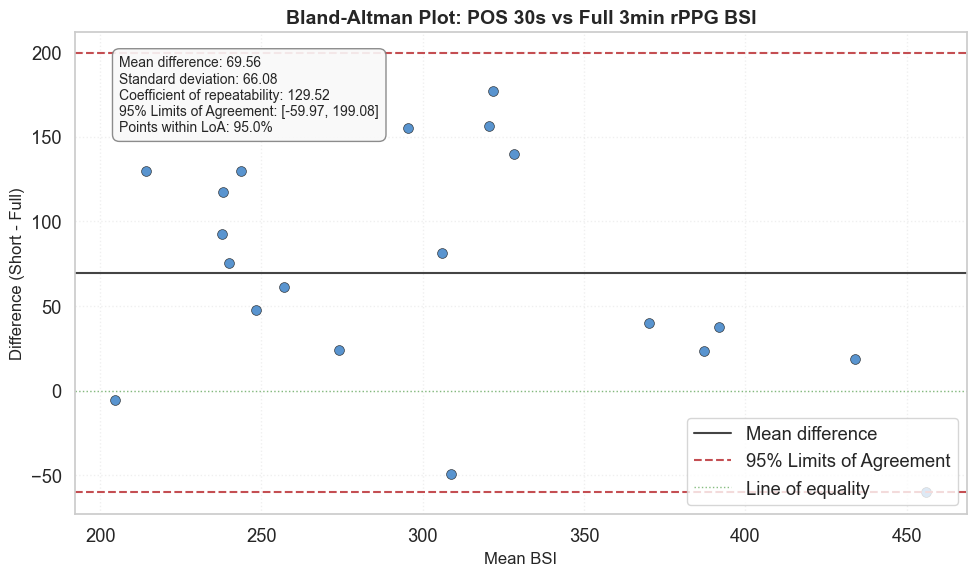

  Creating Bland-Altman plot for LGI method, 30s segment


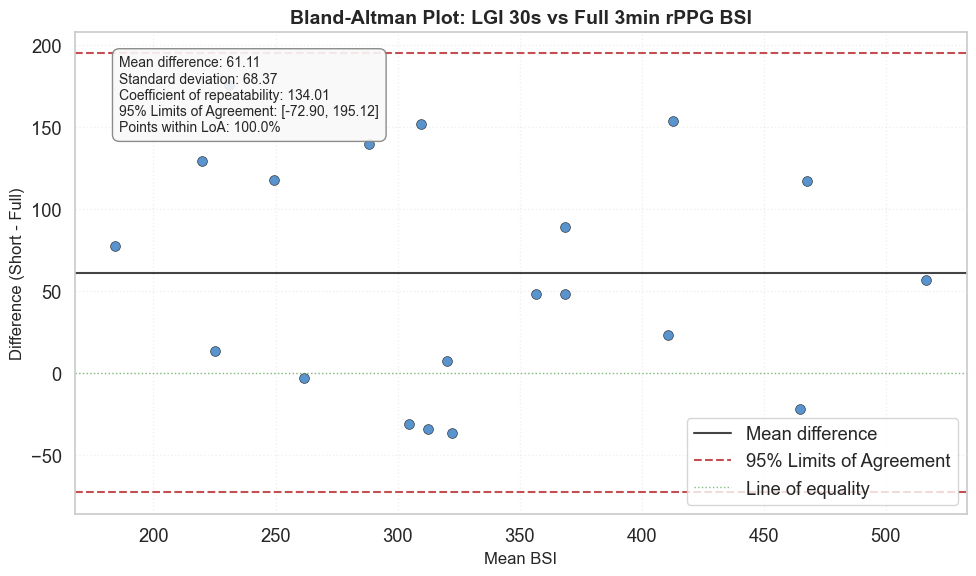

  Creating Bland-Altman plot for OMIT method, 30s segment


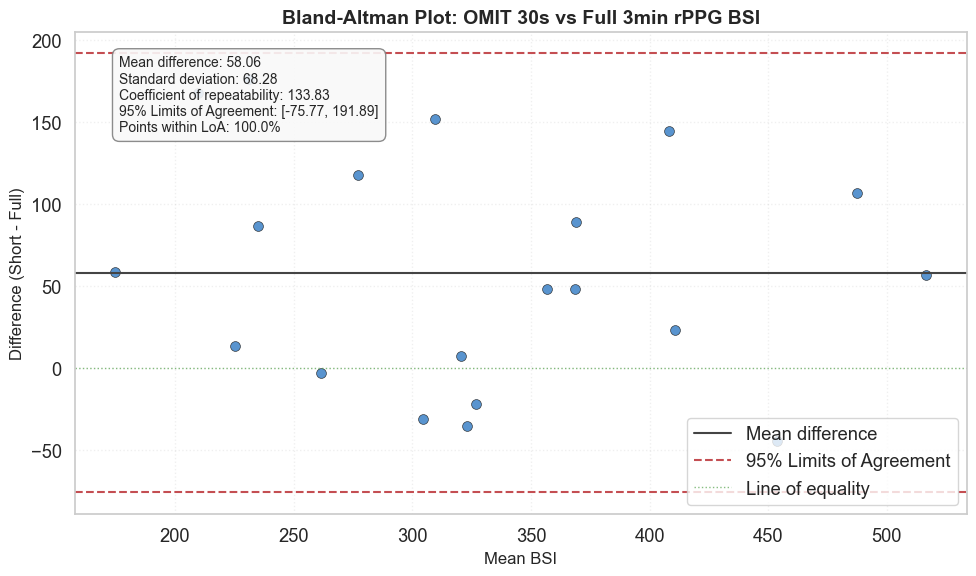

  Creating Bland-Altman plot for GREEN method, 30s segment


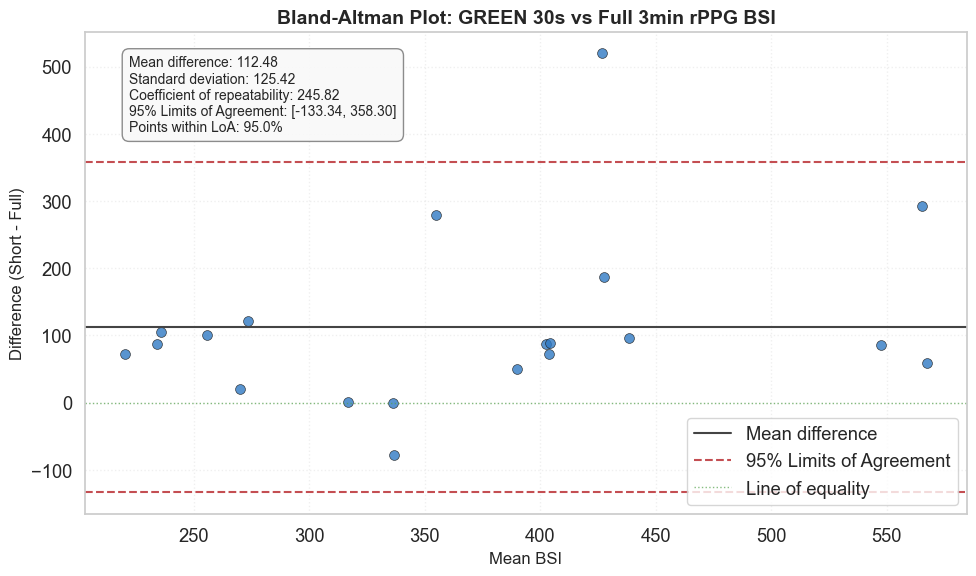

  Creating Bland-Altman plot for CHROM method, 30s segment


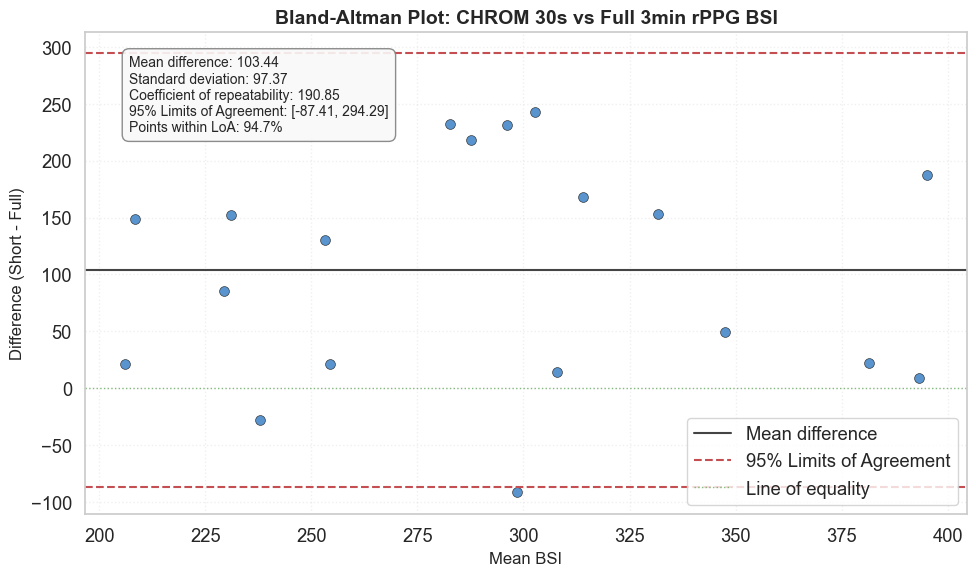

In [66]:
# Step 3: Analyze correlation between short-term rPPG and full-length rPPG
print("\nAnalyzing correlation between short-term rPPG and full-length rPPG...")

# List all available rPPG methods
rppg_methods = ['POS', 'LGI', 'OMIT', 'GREEN', 'CHROM']
segment_lengths = [30, 60]  # seconds
stride = 5  # seconds

# Create a structure to store results for all methods
all_rppg_self_corr = {}

# Process each rPPG method 
for rppg_method in rppg_methods:
    print(f"\nAnalyzing {rppg_method} rPPG method...")
    
    # We'll group BSI values by segment length for easier analysis
    rppg_bsi_values = {
        '30s': [],
        '1min': [],
        '2min': [],
        'full': []
    }
    
    # Additional structure to store all window data
    rppg_bsi_all_windows = {}
    
    subject_ids = []
    
    # Calculate BSI for different segments of rPPG data
    for subject_id, rr_intervals in rppg_data[rppg_method].items():
        subject_ids.append(subject_id)
        
        for segment_length in segment_lengths:
            segments = segment_data(rr_intervals, segment_length, stride=stride)
            
            # For full recording, store in the original structure
            if segment_length == 60:
                for segment_name, segment_rr_data in segments.items():
                    if len(segment_rr_data) > 0:
                        bsi = compute_bsi(segment_rr_data)
                        rppg_bsi_values['full'].append(bsi)
            else:
                # For windowed segments, collect all BSI values
                segment_bsis = []
                for segment_name, segment_rr_data in segments.items():
                    if len(segment_rr_data) > 0:
                        bsi = compute_bsi(segment_rr_data)
                        segment_bsis.append(bsi)
                
                # Store the mean BSI for each segment length
                if segment_bsis:
                    if segment_length == 30:
                        rppg_bsi_values['30s'].append(np.mean([b for b in segment_bsis if not np.isnan(b)]))
                    
                    # Also store all window data for potential detailed analysis
                    key = f"{subject_id}_{segment_length}s"
                    rppg_bsi_all_windows[key] = segment_bsis
    
    # Convert to arrays for easier analysis
    for segment in ['30s', 'full']:
        print(f"  {rppg_method} Segment {segment} has {len(rppg_bsi_values[segment])} values")
        rppg_bsi_values[segment] = np.array(rppg_bsi_values[segment])
    
    # Apply outlier removal to each segment's BSI values
    print(f"\n  Removing outliers from {rppg_method} BSI values...")
    for segment in ['30s', 'full']:
        # Only apply if we have enough data points
        if len(rppg_bsi_values[segment]) > 5:
            rppg_bsi_values[segment] = remove_outliers(rppg_bsi_values[segment], method='IQR')
        else:
            print(f"  Not enough data points to remove outliers for {segment} segment")
    
    # Calculate correlations between rPPG segments and full rPPG BSI
    # This is the key change - comparing against rPPG full instead of GT full
    correlations = {}
    for segment in ['30s', 'full']:
        # Skip comparing full with itself
        if segment == 'full':
            continue
            
        # Ensure equal lengths for comparison
        min_len = min(len(rppg_bsi_values[segment]), len(rppg_bsi_values['full']))
        if min_len > 3:  # Need at least a few valid points
            # Use only valid values for correlation
            mask = ~np.isnan(rppg_bsi_values[segment][:min_len]) & ~np.isnan(rppg_bsi_values['full'][:min_len])
            if sum(mask) > 3:
                corr, p_value = stats.pearsonr(
                    rppg_bsi_values[segment][:min_len][mask], 
                    rppg_bsi_values['full'][:min_len][mask]
                )
                correlations[segment] = {
                    'pearson_r': corr,
                    'p_value': p_value
                }
    
    # Store results for this method
    all_rppg_self_corr[rppg_method] = {
        'bsi_values': rppg_bsi_values,
        'correlations': correlations,
        'windows': rppg_bsi_all_windows
    }

# Create a comparison plot of all rPPG methods for each segment length
segment_names = ['30s',]  # Removed 'full' since we're comparing against it

for segment in segment_names:
    plt.figure(figsize=(16, 6))
    plt.suptitle(f"Correlation of Short-Term vs Full-Length rPPG: {segment} Segment", fontsize=16)
    
    # Scatterplots
    for i, rppg_method in enumerate(rppg_methods):
        plt.subplot(1, len(rppg_methods), i+1)
        
        if segment in all_rppg_self_corr[rppg_method]['correlations']:
            # Get data
            x_data = all_rppg_self_corr[rppg_method]['bsi_values'][segment]
            y_data = all_rppg_self_corr[rppg_method]['bsi_values']['full']
            
            # Use only valid values for plotting
            min_len = min(len(x_data), len(y_data))
            mask = ~np.isnan(x_data[:min_len]) & ~np.isnan(y_data[:min_len])
            
            if sum(mask) > 3:
                x = x_data[:min_len][mask]
                y = y_data[:min_len][mask]
                
                plt.scatter(x, y, alpha=0.7)
                
                # Add best fit line if we have enough points
                if len(x) > 1:
                    m, b = np.polyfit(x, y, 1)
                    plt.plot(x, m*x + b, 'r--')
                
                corr = all_rppg_self_corr[rppg_method]['correlations'][segment]['pearson_r']
                p_val = all_rppg_self_corr[rppg_method]['correlations'][segment]['p_value']
                plt.title(f"{rppg_method}\nr={corr:.2f}, p={p_val:.3f}")
            else:
                plt.title(f"{rppg_method}\nInsufficient data")
        else:
            plt.title(f"{rppg_method}\nNo correlation data")
            
        plt.xlabel(f"{segment} rPPG BSI")
        plt.ylabel("Full 3min rPPG BSI")
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Create a summary correlation heatmap for all methods and segments
plt.figure(figsize=(10, 6))
heatmap_data = np.zeros((len(rppg_methods), len(segment_names)))

for i, method in enumerate(rppg_methods):
    for j, segment in enumerate(segment_names):
        if segment in all_rppg_self_corr[method]['correlations']:
            heatmap_data[i, j] = all_rppg_self_corr[method]['correlations'][segment]['pearson_r']
        else:
            heatmap_data[i, j] = np.nan

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="RdBu_r", 
            xticklabels=segment_names, yticklabels=rppg_methods,
            cbar_kws={'label': 'Pearson Correlation'}, center=0)

plt.title("Correlation of Short-Term rPPG with Full-Length rPPG BSI", fontsize=14)
plt.tight_layout()
plt.show()

# Find the best segment length for each method
best_segments = {}
for method in rppg_methods:
    best_corr = 0
    best_segment = None
    
    for segment in segment_names:
        if segment in all_rppg_self_corr[method]['correlations']:
            corr = abs(all_rppg_self_corr[method]['correlations'][segment]['pearson_r'])
            if corr > best_corr:
                best_corr = corr
                best_segment = segment
    
    best_segments[method] = (best_segment, best_corr)

# Display summary of best segment lengths
print("\nBest segment length for each rPPG method:")
for method, (segment, corr) in best_segments.items():
    if segment:
        print(f"  {method}: {segment} (r={corr:.2f})")
    else:
        print(f"  {method}: No valid segment found")

# Generate Bland-Altman plots for each method with its best segment
print("\nGenerating Bland-Altman plots...")

for method, (segment, _) in best_segments.items():
    if segment:
        print(f"  Creating Bland-Altman plot for {method} method, {segment} segment")
        
        x_data = all_rppg_self_corr[method]['bsi_values'][segment]
        y_data = all_rppg_self_corr[method]['bsi_values']['full']
        
        min_len = min(len(x_data), len(y_data))
        mask = ~np.isnan(x_data[:min_len]) & ~np.isnan(y_data[:min_len])
        
        if sum(mask) > 3:
            bland_altman_plot(
                x_data[:min_len][mask],
                y_data[:min_len][mask],
                f"Bland-Altman Plot: {method} {segment} vs Full 3min rPPG BSI",
                segment_name=f"{method}_{segment}_self_corr",
                ylabel="Difference (Short - Full)",
                xlabel="Mean BSI"
            )
            plt.show()

### Task 6: HRV Features short rppg vs full rppg


Analyzing correlation between short-term rPPG and full-length rPPG for HRV features...

Analyzing POS rPPG method...
  POS SDNN 30s has 20 values
  POS SDNN full has 20 values
  POS RMSSD 30s has 20 values
  POS RMSSD full has 20 values
  POS meanNN 30s has 20 values
  POS meanNN full has 20 values
  POS meanHR 30s has 20 values
  POS meanHR full has 20 values
  POS pNN50 30s has 20 values
  POS pNN50 full has 20 values
  POS BSI 30s has 20 values
  POS BSI full has 20 values

  Removing outliers from POS HRV values...

Analyzing LGI rPPG method...
  LGI SDNN 30s has 20 values
  LGI SDNN full has 20 values
  LGI RMSSD 30s has 20 values
  LGI RMSSD full has 20 values
  LGI meanNN 30s has 20 values
  LGI meanNN full has 20 values
  LGI meanHR 30s has 20 values
  LGI meanHR full has 20 values
  LGI pNN50 30s has 20 values
  LGI pNN50 full has 20 values
  LGI BSI 30s has 20 values
  LGI BSI full has 20 values

  Removing outliers from LGI HRV values...
Removed 1 outliers using IQR method


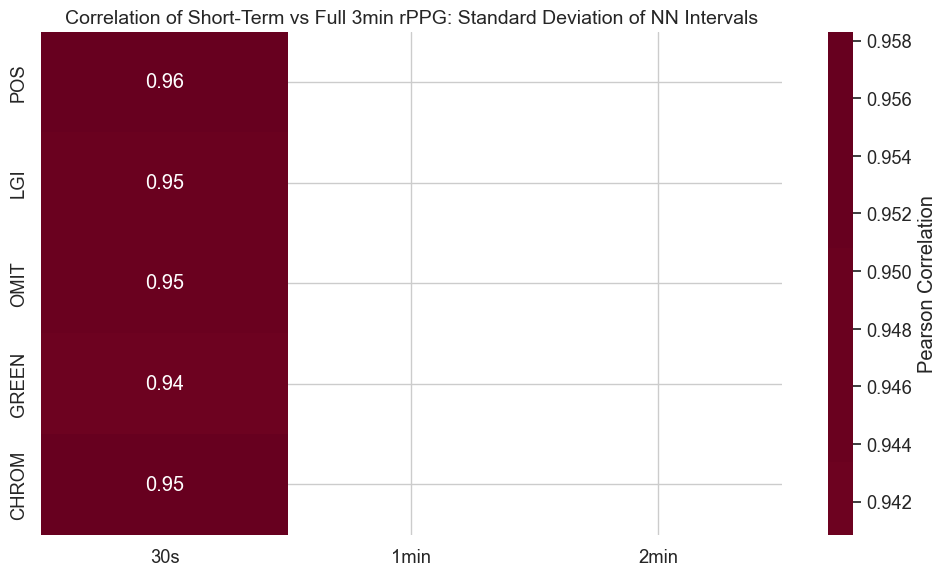

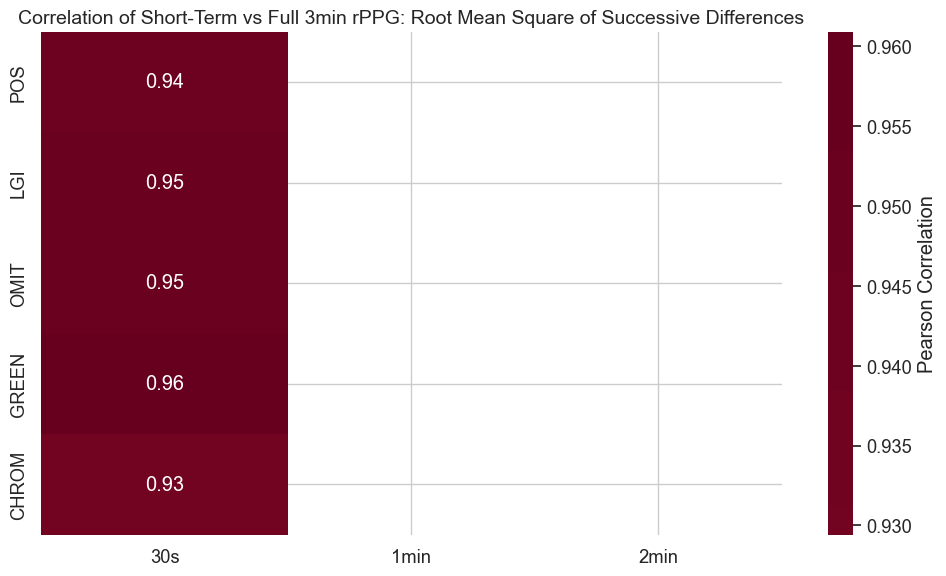

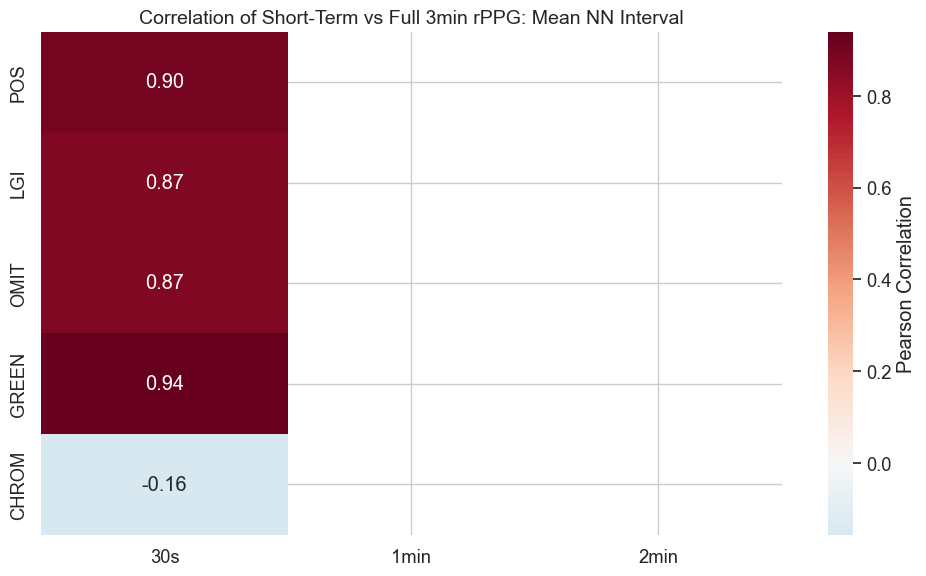

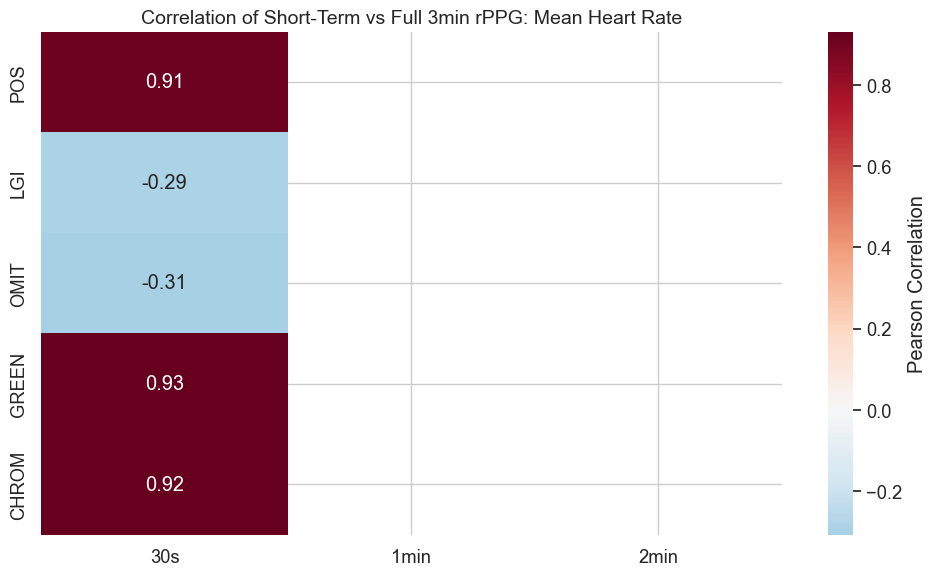

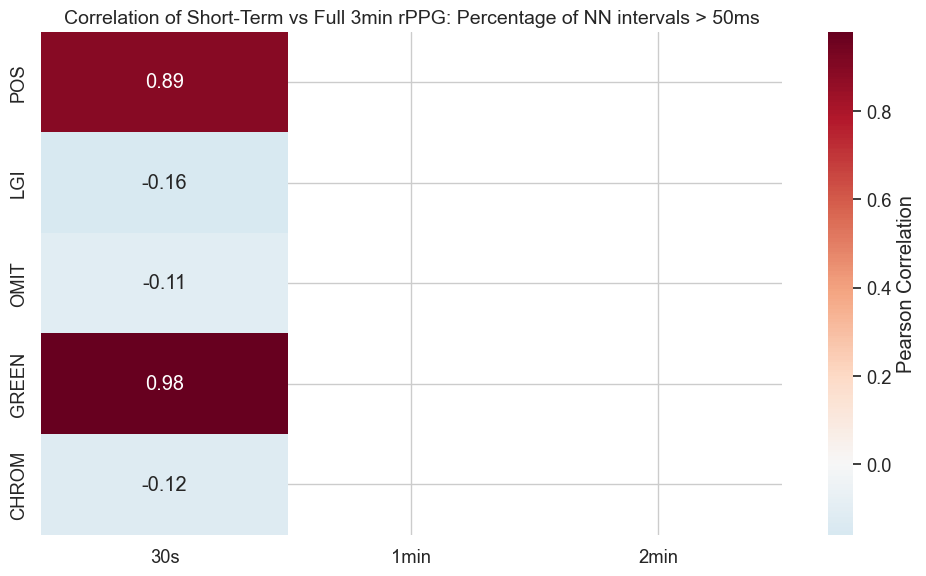

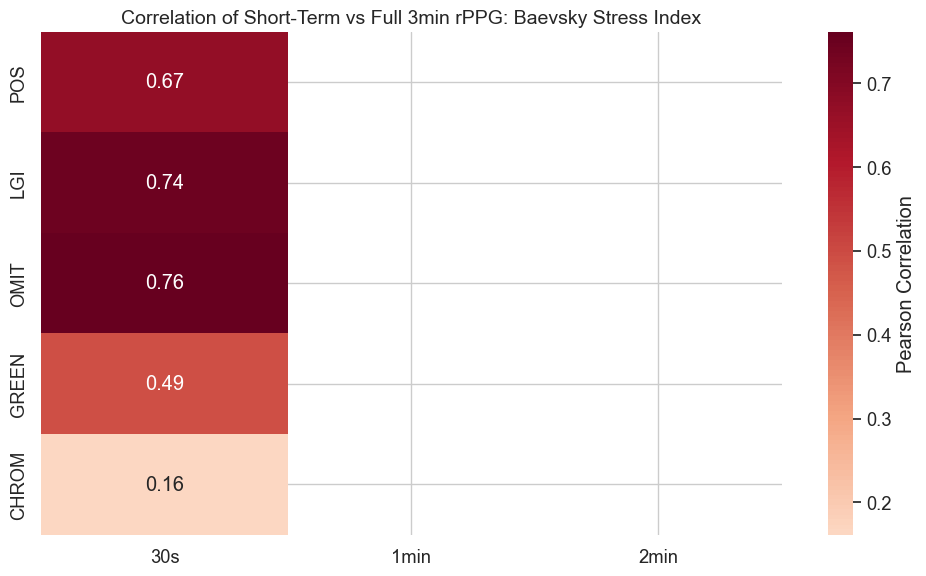


Top 3 features with highest self-correlation: ['SDNN', 'RMSSD', 'meanNN']


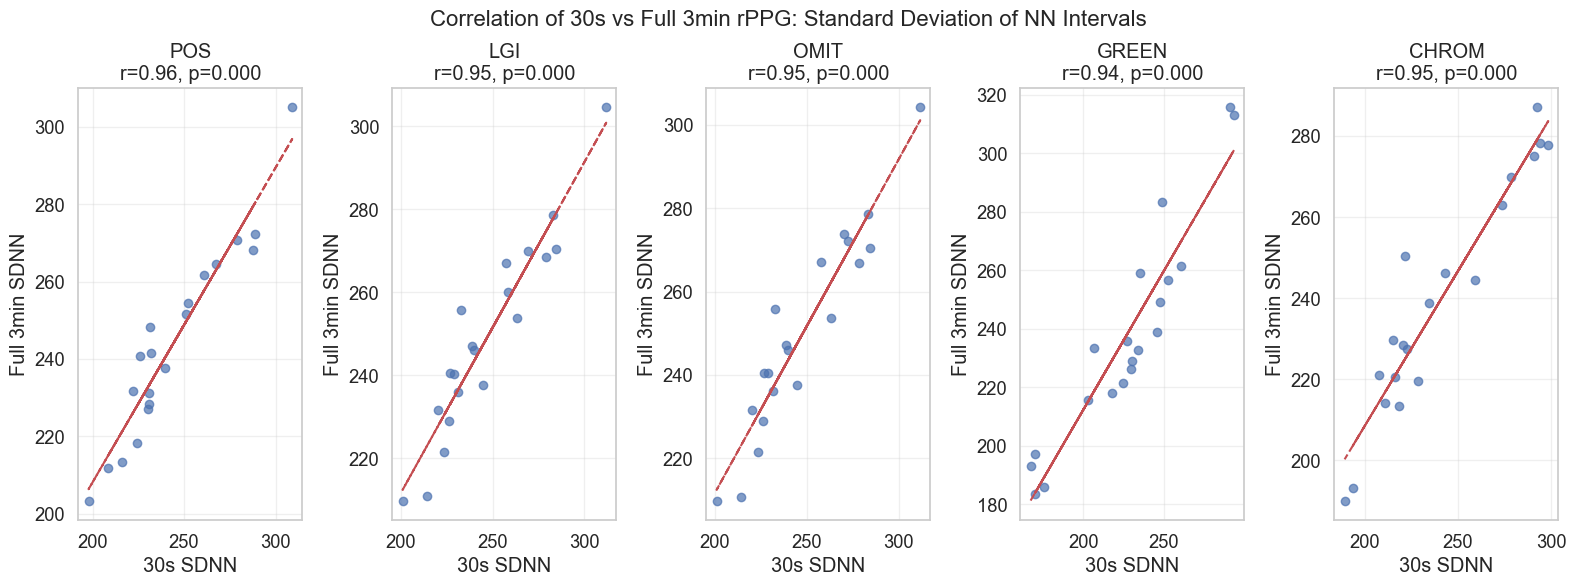

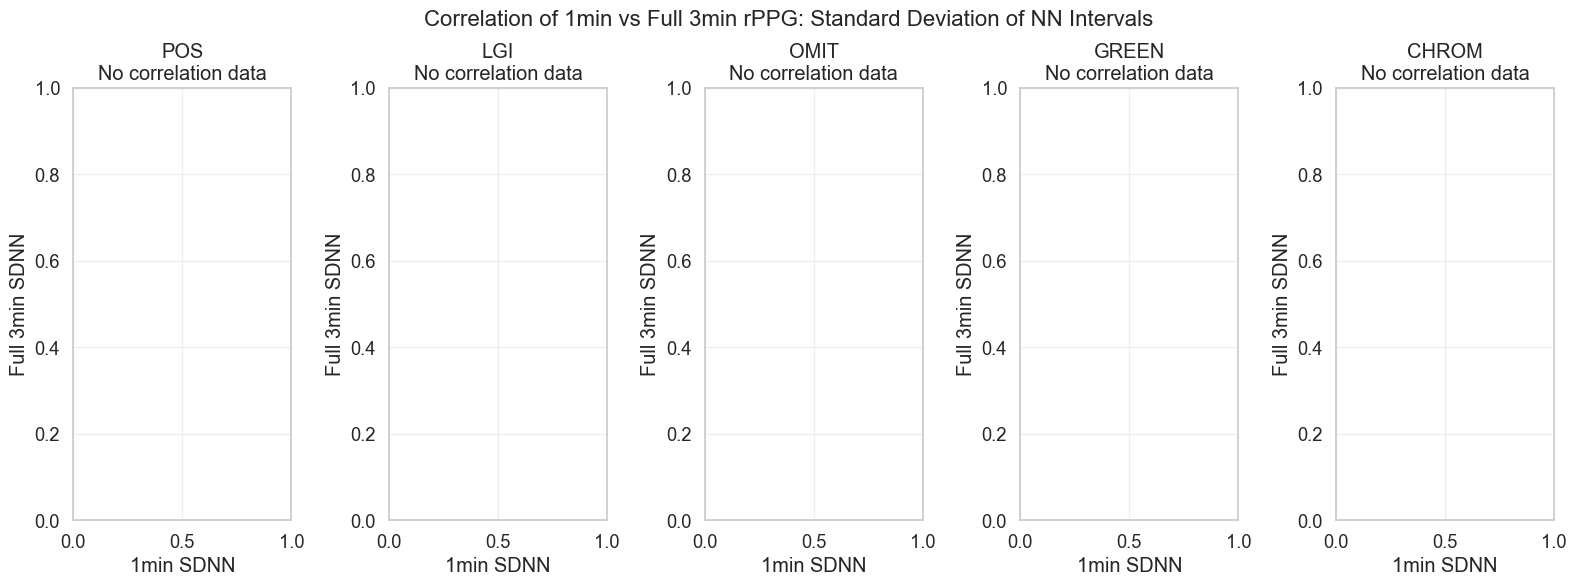

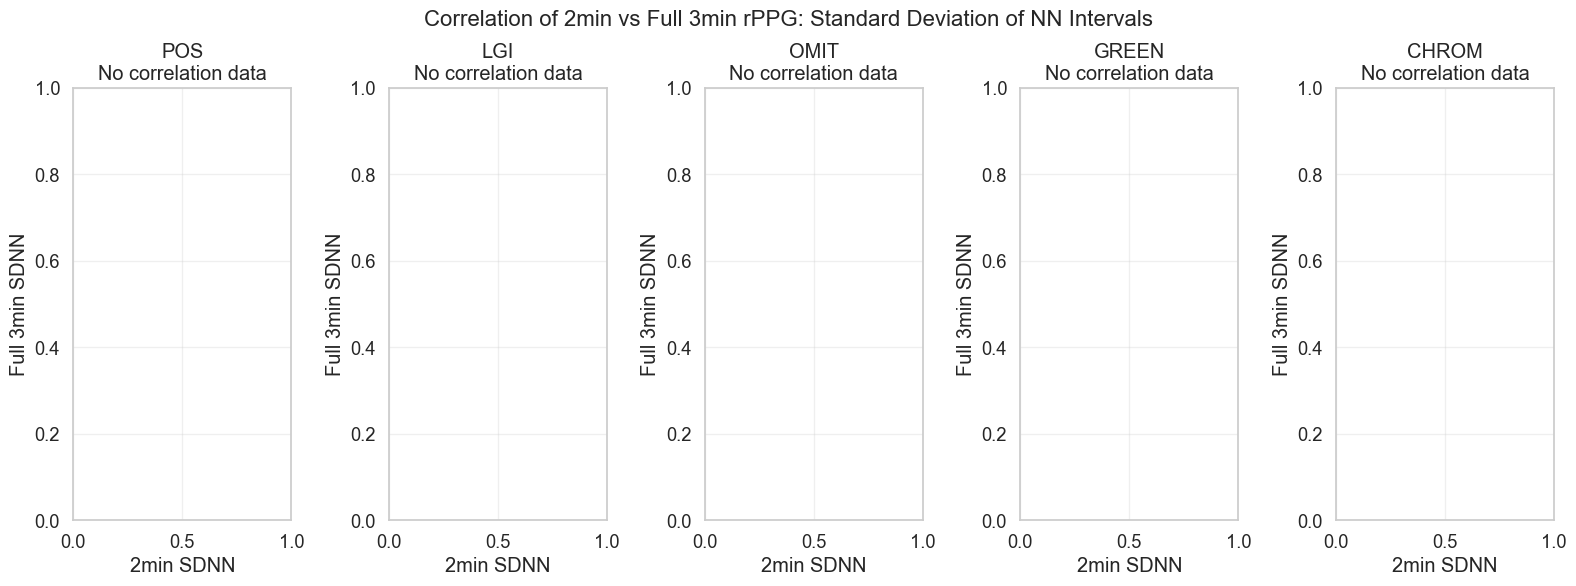

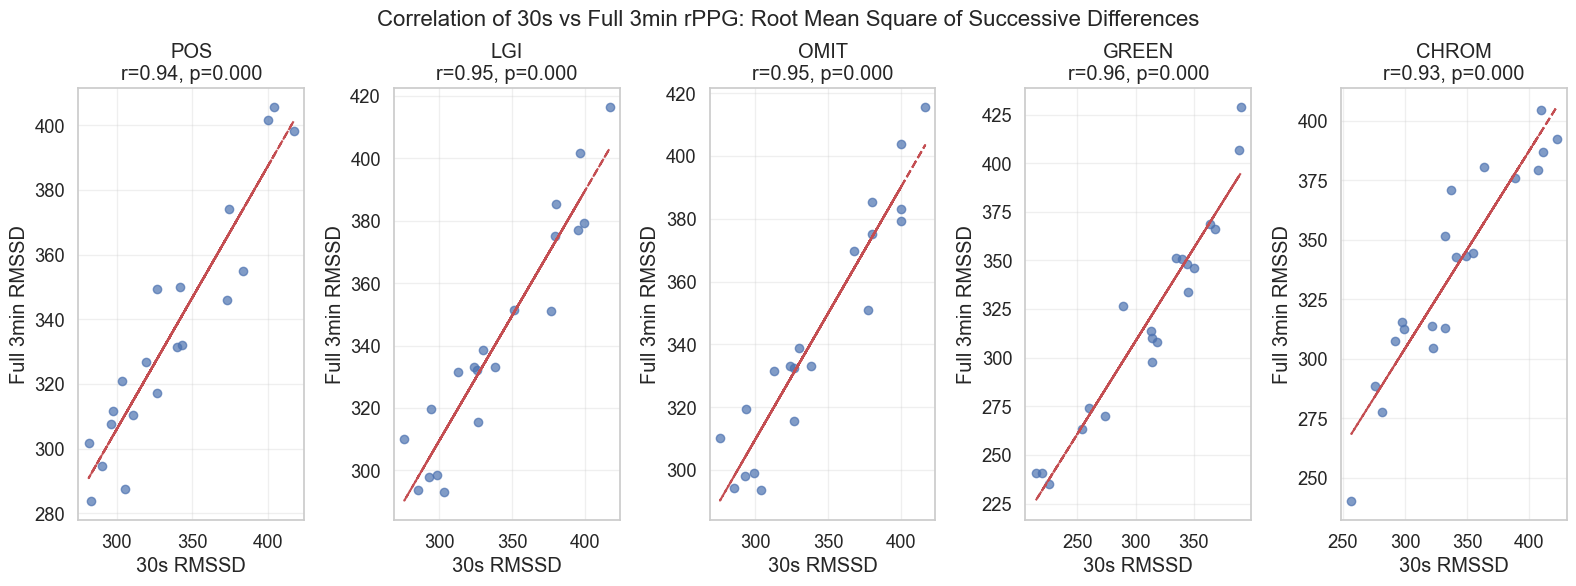

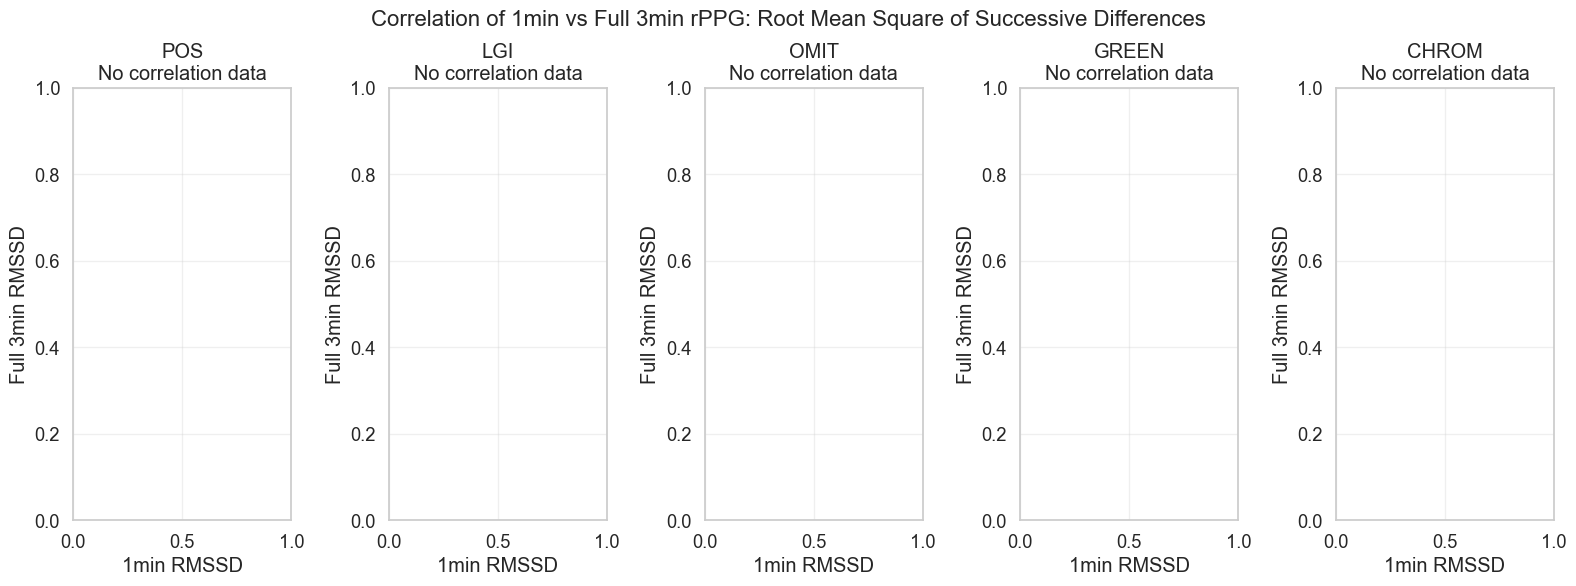

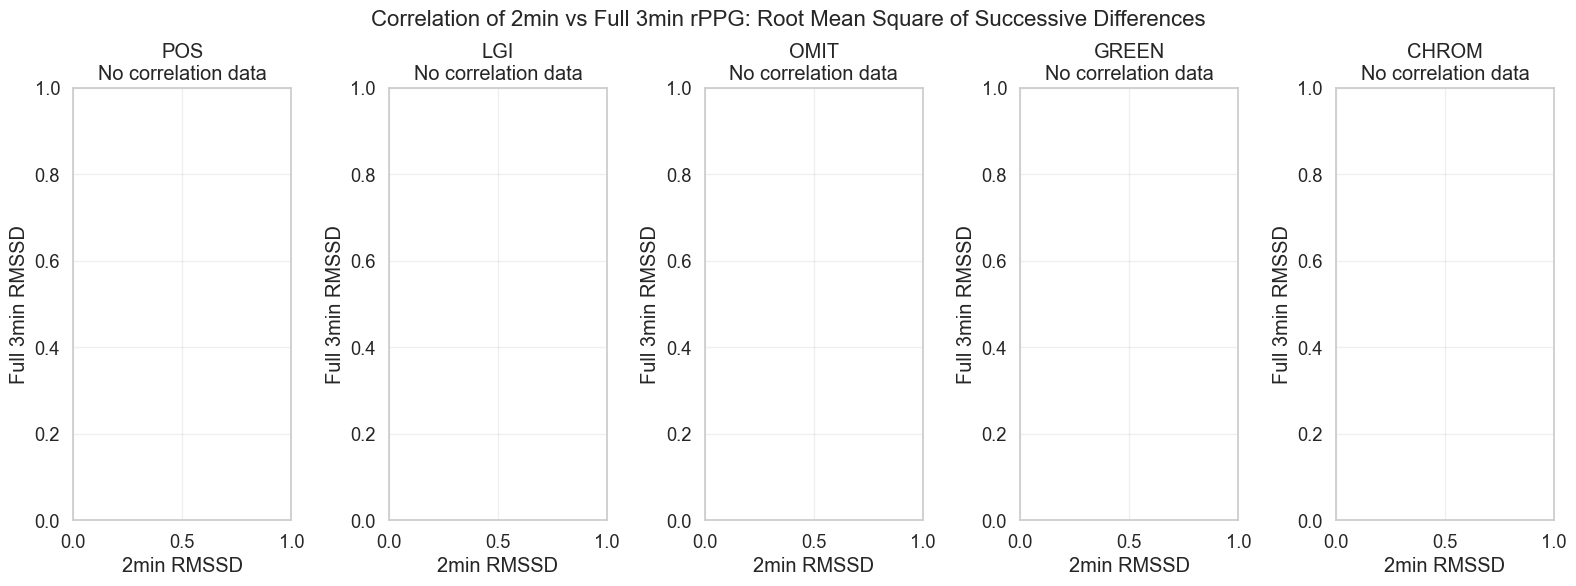

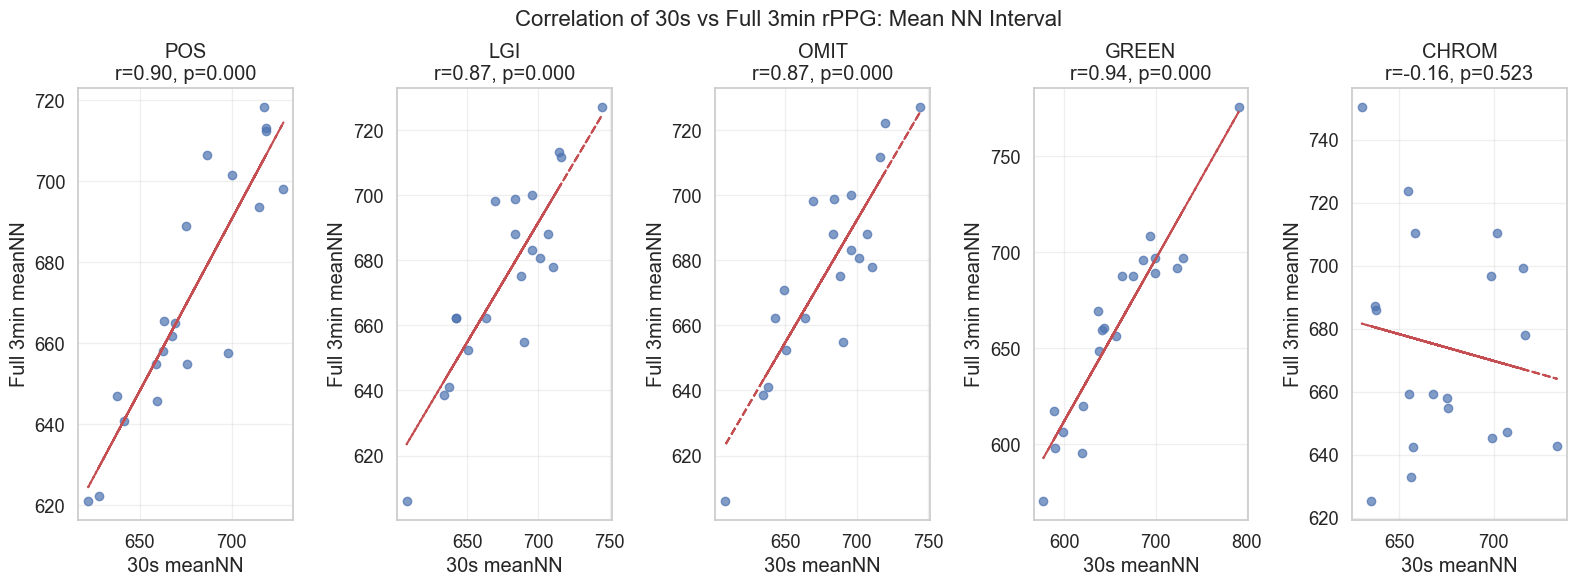

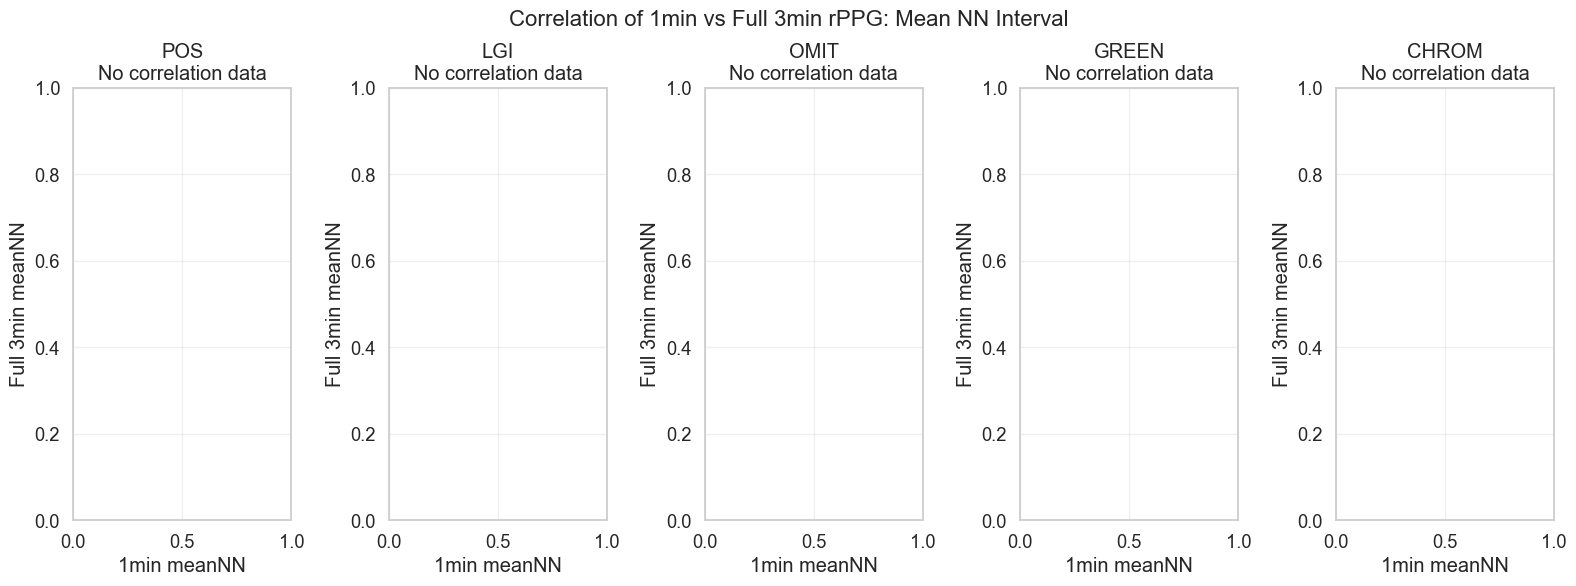

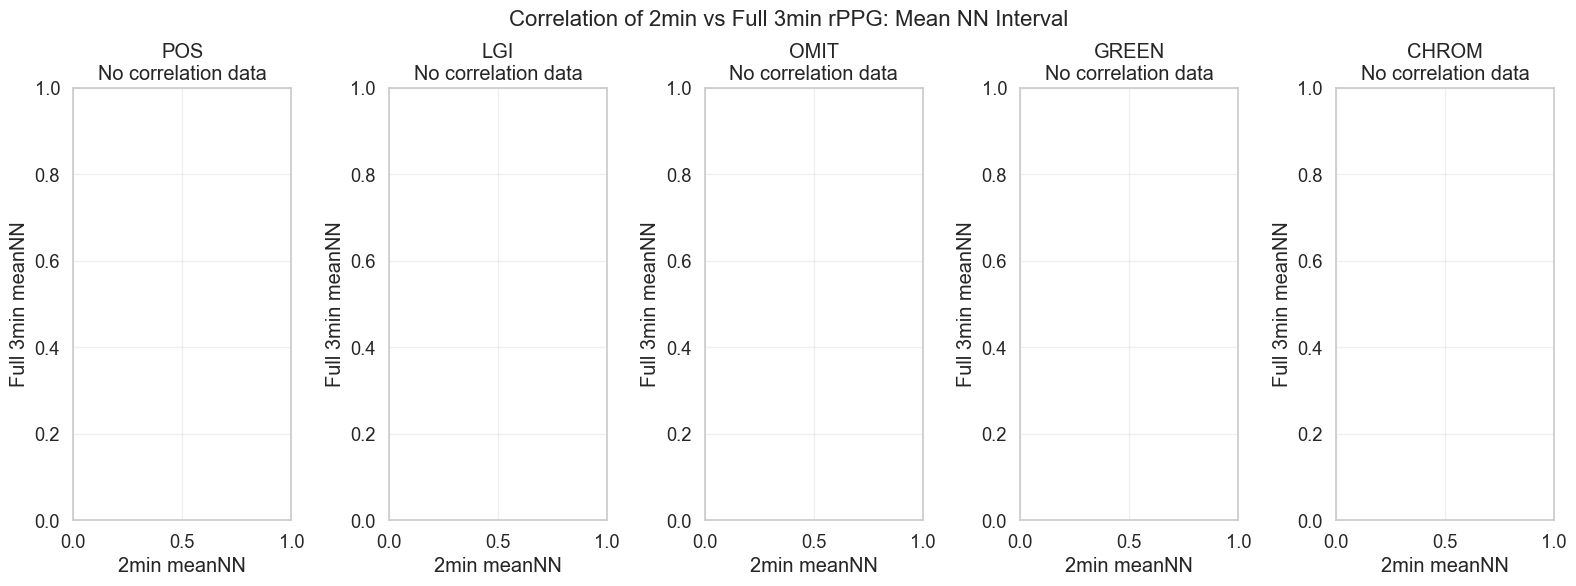


Best segment length for Standard Deviation of NN Intervals:
  POS: 30s (r=0.96)
  LGI: 30s (r=0.95)
  OMIT: 30s (r=0.95)
  GREEN: 30s (r=0.94)
  CHROM: 30s (r=0.95)

Best segment length for Root Mean Square of Successive Differences:
  POS: 30s (r=0.94)
  LGI: 30s (r=0.95)
  OMIT: 30s (r=0.95)
  GREEN: 30s (r=0.96)
  CHROM: 30s (r=0.93)

Best segment length for Mean NN Interval:
  POS: 30s (r=0.90)
  LGI: 30s (r=0.87)
  OMIT: 30s (r=0.87)
  GREEN: 30s (r=0.94)
  CHROM: 30s (r=0.16)

Generating Bland-Altman plots for top features...
  Creating Bland-Altman plot for SDNN, POS method, 30s segment


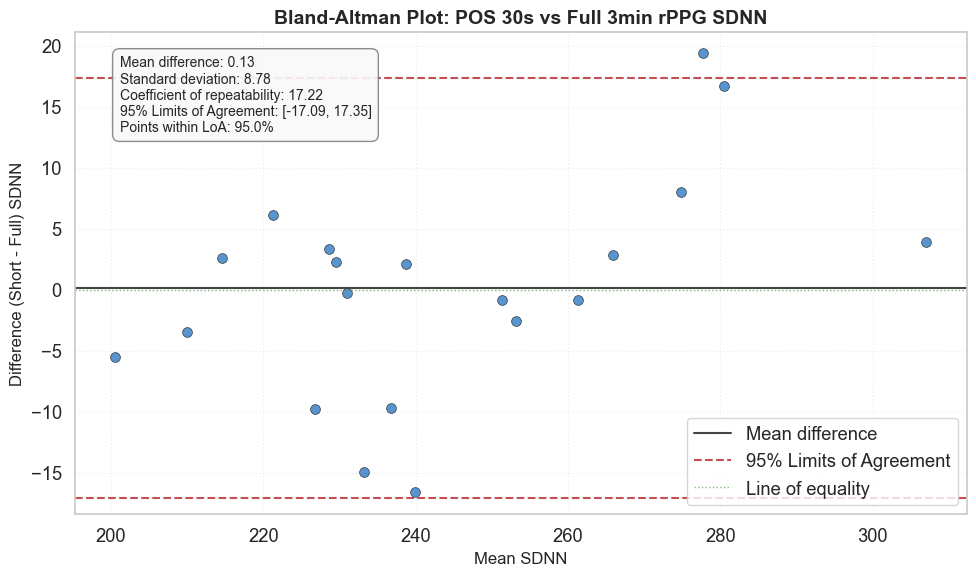

  Creating Bland-Altman plot for RMSSD, GREEN method, 30s segment


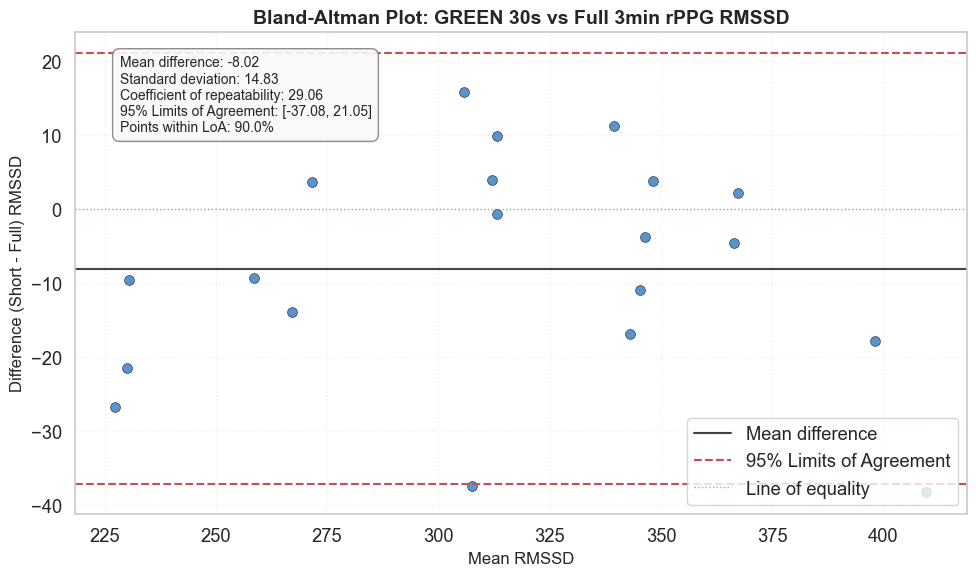

  Creating Bland-Altman plot for meanNN, GREEN method, 30s segment


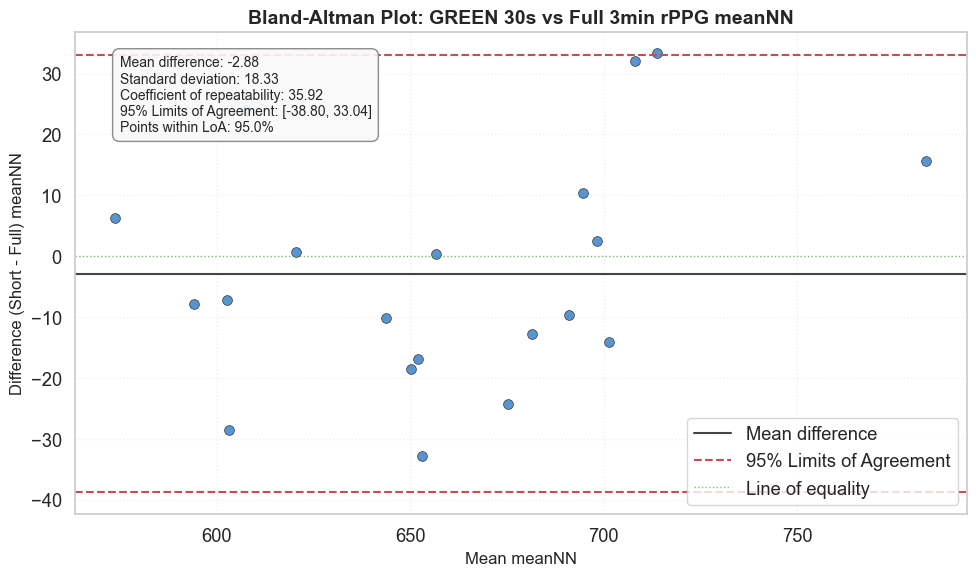


COMPREHENSIVE HRV FEATURE SELF-CORRELATION SUMMARY
Features ranked by how well short-term recordings correlate with full recordings:

1. Standard Deviation of NN Intervals (avg r=0.95)
   Best Method: POS, Best Segment: 30s (r=0.96)

2. Root Mean Square of Successive Differences (avg r=0.95)
   Best Method: GREEN, Best Segment: 30s (r=0.96)

3. Mean NN Interval (avg r=0.75)
   Best Method: GREEN, Best Segment: 30s (r=0.94)

4. Mean Heart Rate (avg r=0.67)
   Best Method: GREEN, Best Segment: 30s (r=0.93)

5. Baevsky Stress Index (avg r=0.57)
   Best Method: OMIT, Best Segment: 30s (r=0.76)

6. Percentage of NN intervals > 50ms (avg r=0.45)
   Best Method: GREEN, Best Segment: 30s (r=0.98)

MOST STABLE FEATURE: Standard Deviation of NN Intervals
This feature shows the strongest correlation between short and full recordings
Best implementation: POS method with 30s segment length


In [ ]:
# Step 3: Analyze correlation between short-term rPPG and full-length rPPG for all HRV features
print("\nAnalyzing correlation between short-term rPPG and full-length rPPG for HRV features...")

# List all available rPPG methods
rppg_methods = ['POS', 'LGI', 'OMIT', 'GREEN', 'CHROM']
segment_lengths = [30, 60]  # seconds
stride = 5  # seconds

# List of HRV features to analyze
hrv_features = ['SDNN', 'RMSSD', 'meanNN', 'meanHR', 'pNN50', 'BSI']

# Create a structure to store results for all methods and features
all_rppg_self_corr = {}

# Process each rPPG method 
for rppg_method in rppg_methods:
    print(f"\nAnalyzing {rppg_method} rPPG method...")
    
    # Initialize structure to store HRV feature values for this method
    rppg_hrv_values = {
        feature: {
            '30s': [],
            '1min': [],
            '2min': [],
            'full': []
        } for feature in hrv_features
    }
    
    # Additional structure to store all window data
    rppg_hrv_all_windows = {feature: {} for feature in hrv_features}
    
    subject_ids = []
    
    # Calculate HRV features for different segments of rPPG data
    for subject_id, rr_intervals in rppg_data[rppg_method].items():
        subject_ids.append(subject_id)
        
        for segment_length in segment_lengths:
            segments = segment_data(rr_intervals, segment_length, stride=stride)
            
            # For full recording, store in the original structure
            if segment_length == 60:
                for segment_name, segment_rr_data in segments.items():
                    if len(segment_rr_data) > 0:
                        # Calculate all HRV features
                        hrv_data = compute_hrv_features(segment_rr_data)
                        for feature in hrv_features:
                            rppg_hrv_values[feature]['full'].append(hrv_data[feature])
            else:
                # For windowed segments, collect all feature values
                segment_features = {feature: [] for feature in hrv_features}
                
                for segment_name, segment_rr_data in segments.items():
                    if len(segment_rr_data) > 0:
                        # Calculate all HRV features for this window
                        hrv_data = compute_hrv_features(segment_rr_data)
                        
                        # Store each feature separately
                        for feature in hrv_features:
                            segment_features[feature].append(hrv_data[feature])
                
                # Store the mean value for each feature and segment length
                for feature in hrv_features:
                    valid_values = [v for v in segment_features[feature] if not np.isnan(v)]
                    if valid_values:
                        if segment_length == 30:
                            rppg_hrv_values[feature]['30s'].append(np.mean(valid_values))
                
                # Also store all window data for potential detailed analysis
                for feature in hrv_features:
                    key = f"{subject_id}_{segment_length}s"
                    if key not in rppg_hrv_all_windows[feature]:
                        rppg_hrv_all_windows[feature][key] = segment_features[feature]
    
    # Convert to arrays for easier analysis
    for feature in hrv_features:
        for segment in ['30s', 'full']:
            print(f"  {rppg_method} {feature} {segment} has {len(rppg_hrv_values[feature][segment])} values")
            rppg_hrv_values[feature][segment] = np.array(rppg_hrv_values[feature][segment])
    
    # Apply outlier removal to each feature's values
    print(f"\n  Removing outliers from {rppg_method} HRV values...")
    for feature in hrv_features:
        for segment in ['30s', 'full']:
            # Only apply if we have enough data points
            if len(rppg_hrv_values[feature][segment]) > 5:
                rppg_hrv_values[feature][segment] = remove_outliers(rppg_hrv_values[feature][segment], method='IQR')
            else:
                print(f"  Not enough data points to remove outliers for {feature} {segment} segment")
    
    # Calculate correlations between short-term and full-length rPPG for each feature
    # This is comparing against the same method's full length recording
    correlations = {feature: {} for feature in hrv_features}
    
    for feature in hrv_features:
        for segment in ['30s']:
            # Ensure equal lengths for comparison
            min_len = min(len(rppg_hrv_values[feature][segment]), len(rppg_hrv_values[feature]['full']))
            if min_len > 3:  # Need at least a few valid points
                # Use only valid values for correlation
                mask = ~np.isnan(rppg_hrv_values[feature][segment][:min_len]) & ~np.isnan(rppg_hrv_values[feature]['full'][:min_len])
                if sum(mask) > 3:
                    corr, p_value = stats.pearsonr(
                        rppg_hrv_values[feature][segment][:min_len][mask], 
                        rppg_hrv_values[feature]['full'][:min_len][mask]
                    )
                    correlations[feature][segment] = {
                        'pearson_r': corr,
                        'p_value': p_value
                    }
    
    # Store results for this method
    all_rppg_self_corr[rppg_method] = {
        'hrv_values': rppg_hrv_values,
        'correlations': correlations,
        'windows': rppg_hrv_all_windows
    }

# Feature display names for better plots
feature_display_names = {
    'SDNN': 'Standard Deviation of NN Intervals',
    'RMSSD': 'Root Mean Square of Successive Differences',
    'meanNN': 'Mean NN Interval',
    'meanHR': 'Mean Heart Rate',
    'pNN50': 'Percentage of NN intervals > 50ms',
    'BSI': 'Baevsky Stress Index'
}

# Create a summary correlation heatmaps for each feature
segment_names = ['30s', '1min', '2min']

for feature in hrv_features:
    plt.figure(figsize=(10, 6))
    heatmap_data = np.zeros((len(rppg_methods), len(segment_names)))
    
    for i, method in enumerate(rppg_methods):
        for j, segment in enumerate(segment_names):
            if segment in all_rppg_self_corr[method]['correlations'][feature]:
                heatmap_data[i, j] = all_rppg_self_corr[method]['correlations'][feature][segment]['pearson_r']
            else:
                heatmap_data[i, j] = np.nan
    
    # Create heatmap
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="RdBu_r", 
                xticklabels=segment_names, yticklabels=rppg_methods,
                cbar_kws={'label': 'Pearson Correlation'}, center=0)
    
    plt.title(f"Correlation of Short-Term vs Full 3min rPPG: {feature_display_names[feature]}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot top 3 most promising features in more detail
# Calculate average correlation for each feature across all methods and segments
feature_avg_corr = {}
for feature in hrv_features:
    correlations = []
    for method in rppg_methods:
        for segment in segment_names:
            if segment in all_rppg_self_corr[method]['correlations'][feature]:
                correlations.append(abs(all_rppg_self_corr[method]['correlations'][feature][segment]['pearson_r']))
    
    if correlations:
        feature_avg_corr[feature] = np.mean(correlations)
    else:
        feature_avg_corr[feature] = 0

# Sort features by average correlation strength
sorted_features = sorted(feature_avg_corr.items(), key=lambda x: x[1], reverse=True)
top_features = [f[0] for f in sorted_features[:3]]  # Top 3 features

print(f"\nTop 3 features with highest self-correlation: {top_features}")

# Create detailed plots for top features
for feature in top_features:
    for segment in segment_names:
        plt.figure(figsize=(16, 6))
        plt.suptitle(f"Correlation of {segment} vs Full 3min rPPG: {feature_display_names[feature]}", fontsize=16)
        
        # Scatterplots for each method
        for i, rppg_method in enumerate(rppg_methods):
            plt.subplot(1, len(rppg_methods), i+1)
            
            if segment in all_rppg_self_corr[rppg_method]['correlations'][feature]:
                # Get data
                x_data = all_rppg_self_corr[rppg_method]['hrv_values'][feature][segment]
                y_data = all_rppg_self_corr[rppg_method]['hrv_values'][feature]['full']
                
                # Use only valid values for plotting
                min_len = min(len(x_data), len(y_data))
                mask = ~np.isnan(x_data[:min_len]) & ~np.isnan(y_data[:min_len])
                
                if sum(mask) > 3:
                    x = x_data[:min_len][mask]
                    y = y_data[:min_len][mask]
                    
                    plt.scatter(x, y, alpha=0.7)
                    
                    # Add best fit line if we have enough points
                    if len(x) > 1:
                        m, b = np.polyfit(x, y, 1)
                        plt.plot(x, m*x + b, 'r--')
                    
                    corr = all_rppg_self_corr[rppg_method]['correlations'][feature][segment]['pearson_r']
                    p_val = all_rppg_self_corr[rppg_method]['correlations'][feature][segment]['p_value']
                    plt.title(f"{rppg_method}\nr={corr:.2f}, p={p_val:.3f}")
                else:
                    plt.title(f"{rppg_method}\nInsufficient data")
            else:
                plt.title(f"{rppg_method}\nNo correlation data")
                
            plt.xlabel(f"{segment} {feature}")
            plt.ylabel(f"Full 3min {feature}")
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

# Find the best segment length for each feature and method combination
best_segments = {feature: {} for feature in hrv_features}

for feature in hrv_features:
    for method in rppg_methods:
        best_corr = 0
        best_segment = None
        
        for segment in segment_names:
            if segment in all_rppg_self_corr[method]['correlations'][feature]:
                corr = abs(all_rppg_self_corr[method]['correlations'][feature][segment]['pearson_r'])
                if corr > best_corr:
                    best_corr = corr
                    best_segment = segment
        
        if best_segment:
            best_segments[feature][method] = (best_segment, best_corr)

# Display summary of best segment lengths for each feature and method
for feature in top_features:
    print(f"\nBest segment length for {feature_display_names[feature]}:")
    for method, (segment, corr) in best_segments[feature].items():
        print(f"  {method}: {segment} (r={corr:.2f})")

# Generate Bland-Altman plots for the best method/segment for each top feature
print("\nGenerating Bland-Altman plots for top features...")

for feature in top_features:
    # Find best method for this feature
    best_method = None
    best_segment = None
    best_r = 0
    
    for method, segments in best_segments[feature].items():
        segment, r = segments
        if r > best_r:
            best_r = r
            best_method = method
            best_segment = segment
    
    if best_method and best_segment:
        print(f"  Creating Bland-Altman plot for {feature}, {best_method} method, {best_segment} segment")
        
        x_data = all_rppg_self_corr[best_method]['hrv_values'][feature][best_segment]
        y_data = all_rppg_self_corr[best_method]['hrv_values'][feature]['full']
        
        min_len = min(len(x_data), len(y_data))
        mask = ~np.isnan(x_data[:min_len]) & ~np.isnan(y_data[:min_len])
        
        if sum(mask) > 3:
            bland_altman_plot(
                x_data[:min_len][mask],
                y_data[:min_len][mask],
                f"Bland-Altman Plot: {best_method} {best_segment} vs Full 3min rPPG {feature}",
                segment_name=f"{best_method}_{best_segment}_{feature}_self_corr",
                ylabel=f"Difference (Short - Full) {feature}",
                xlabel=f"Mean {feature}"
            )
            plt.show()

# Create an overall summary showing which features maintain best correlation
overall_results = []

for feature in hrv_features:
    avg_corr = feature_avg_corr[feature]
    
    # Find the best method and segment for this feature
    best_method = None
    best_segment = None
    best_r = 0
    
    for method, segments in best_segments[feature].items():
        if segments:
            segment, r = segments
            if r > best_r:
                best_r = r
                best_method = method
                best_segment = segment
    
    overall_results.append({
        'feature': feature,
        'display_name': feature_display_names[feature],
        'avg_corr': avg_corr,
        'best_method': best_method,
        'best_segment': best_segment,
        'best_r': best_r
    })

# Sort results by average correlation
overall_results.sort(key=lambda x: x['avg_corr'], reverse=True)

# Display comprehensive summary
print("\n" + "="*60)
print("COMPREHENSIVE HRV FEATURE SELF-CORRELATION SUMMARY")
print("="*60)
print("Features ranked by how well short-term recordings correlate with full recordings:\n")

for i, result in enumerate(overall_results):
    print(f"{i+1}. {result['display_name']} (avg r={result['avg_corr']:.2f})")
    if result['best_method']:
        print(f"   Best Method: {result['best_method']}, Best Segment: {result['best_segment']} (r={result['best_r']:.2f})")
    else:
        print("   No valid correlation data")
    print()

# Highlight most stable feature
if overall_results:
    best_feature = overall_results[0]
    print(f"MOST STABLE FEATURE: {best_feature['display_name']}")
    print(f"This feature shows the strongest correlation between short and full recordings")
    print(f"Best implementation: {best_feature['best_method']} method with {best_feature['best_segment']} segment length")